# Fully-Connected Neural Nets

In this notebook we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
  
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [110]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from deeplearning.classifiers.fc_net import *
from deeplearning.data_utils import get_CIFAR10_data
from deeplearning.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from deeplearning.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

deeplearning/datasets/cifar-10-batches-py/data_batch_1
deeplearning/datasets/cifar-10-batches-py/data_batch_2
deeplearning/datasets/cifar-10-batches-py/data_batch_3
deeplearning/datasets/cifar-10-batches-py/data_batch_4
deeplearning/datasets/cifar-10-batches-py/data_batch_5
deeplearning/datasets/cifar-10-batches-py/test_batch
X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In [14]:
28*28

784

In [24]:
x_toy = np.ones((3, 9))
w_toy = np.ones((9, 2))
b_toy = np.array([[3,1]])
out_toy = x_toy @ w_toy + b_toy

In [30]:
np.sum(out_toy, axis = 0)

array([36., 30.])

# Affine layer: forward
Open the file `deeplearning/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [12]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [35]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)
# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  3.423821505311987e-11
dw error:  1.9587915072248264e-10
db error:  1.9360938969566527e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [36]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking. Note that the ReLU activation is not differentiable at 0, but typically we don't worry about this and simply assign either 0 or 1 as the derivative by convention.

In [51]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756311088673524e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `deeplearning/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [52]:
from deeplearning.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  2.507267037345914e-11
dw error:  9.60230874692481e-10
db error:  3.4245345554348826e-11


# Loss layers: Softmax and SVM
Here we provide two loss functions that we will use to train our deep neural networks. You should understand how they work by looking at the implementations in `deeplearnign/layers.py`.

You can make sure that the implementations are correct by running the following:

In [53]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  9.000869731165501
dx error:  8.182894472887002e-10

Testing softmax_loss:
loss:  2.302672511447244
dx error:  1.0464480265119163e-08


# Two-layer network

Open the file `deeplearning/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. Run the cell below to test your implementation.

In [76]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print ('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print ('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print ('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
    print ('Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.20e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 7.98e-08
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


# Solver
Following a modular design, for this assignment we have split the logic for training models into a separate class from the models themselves.

Open the file `deeplearning/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [86]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
optim_config = {}
optim_config['learning_rate'] = 0.0005
solver = Solver(model, data, optim_config=optim_config, lr_decay=0.9, num_epochs=30)
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 14700) loss: 2.298774
(Epoch 0 / 30) train acc: 0.095000; val_acc: 0.091000
(Iteration 11 / 14700) loss: 2.275745
(Iteration 21 / 14700) loss: 2.255965
(Iteration 31 / 14700) loss: 2.208797
(Iteration 41 / 14700) loss: 2.115136
(Iteration 51 / 14700) loss: 2.015048
(Iteration 61 / 14700) loss: 2.001671
(Iteration 71 / 14700) loss: 1.984067
(Iteration 81 / 14700) loss: 1.973135
(Iteration 91 / 14700) loss: 2.007147
(Iteration 101 / 14700) loss: 1.960284
(Iteration 111 / 14700) loss: 1.809629
(Iteration 121 / 14700) loss: 1.711912
(Iteration 131 / 14700) loss: 1.844762
(Iteration 141 / 14700) loss: 1.971592
(Iteration 151 / 14700) loss: 1.865051
(Iteration 161 / 14700) loss: 1.774848
(Iteration 171 / 14700) loss: 1.622283
(Iteration 181 / 14700) loss: 1.845661
(Iteration 191 / 14700) loss: 1.961516
(Iteration 201 / 14700) loss: 1.747247
(Iteration 211 / 14700) loss: 1.840129
(Iteration 221 / 14700) loss: 1.811269
(Iteration 231 / 14700) loss: 1.620670
(Iteration 241 / 1470

(Iteration 2011 / 14700) loss: 1.215652
(Iteration 2021 / 14700) loss: 1.543863
(Iteration 2031 / 14700) loss: 1.230254
(Iteration 2041 / 14700) loss: 1.433111
(Iteration 2051 / 14700) loss: 1.365882
(Iteration 2061 / 14700) loss: 1.316398
(Iteration 2071 / 14700) loss: 1.376921
(Iteration 2081 / 14700) loss: 1.165036
(Iteration 2091 / 14700) loss: 1.360939
(Iteration 2101 / 14700) loss: 1.521057
(Iteration 2111 / 14700) loss: 1.354830
(Iteration 2121 / 14700) loss: 1.490432
(Iteration 2131 / 14700) loss: 1.131443
(Iteration 2141 / 14700) loss: 1.377708
(Iteration 2151 / 14700) loss: 1.430508
(Iteration 2161 / 14700) loss: 1.474820
(Iteration 2171 / 14700) loss: 1.239757
(Iteration 2181 / 14700) loss: 1.342202
(Iteration 2191 / 14700) loss: 1.302977
(Iteration 2201 / 14700) loss: 1.395239
(Iteration 2211 / 14700) loss: 1.432861
(Iteration 2221 / 14700) loss: 1.306889
(Iteration 2231 / 14700) loss: 1.444380
(Iteration 2241 / 14700) loss: 1.361526
(Iteration 2251 / 14700) loss: 1.330607


(Iteration 4041 / 14700) loss: 1.196588
(Iteration 4051 / 14700) loss: 1.120742
(Iteration 4061 / 14700) loss: 1.258552
(Iteration 4071 / 14700) loss: 1.293613
(Iteration 4081 / 14700) loss: 1.103580
(Iteration 4091 / 14700) loss: 1.196900
(Iteration 4101 / 14700) loss: 1.240672
(Iteration 4111 / 14700) loss: 1.365236
(Iteration 4121 / 14700) loss: 1.203997
(Iteration 4131 / 14700) loss: 1.335557
(Iteration 4141 / 14700) loss: 1.234003
(Iteration 4151 / 14700) loss: 1.406148
(Iteration 4161 / 14700) loss: 1.236863
(Iteration 4171 / 14700) loss: 1.175527
(Iteration 4181 / 14700) loss: 1.021601
(Iteration 4191 / 14700) loss: 1.207423
(Iteration 4201 / 14700) loss: 1.251616
(Iteration 4211 / 14700) loss: 1.379567
(Iteration 4221 / 14700) loss: 1.228749
(Iteration 4231 / 14700) loss: 1.062574
(Iteration 4241 / 14700) loss: 1.010747
(Iteration 4251 / 14700) loss: 1.337588
(Iteration 4261 / 14700) loss: 1.302065
(Iteration 4271 / 14700) loss: 1.106751
(Iteration 4281 / 14700) loss: 1.214908


(Iteration 6051 / 14700) loss: 1.186115
(Iteration 6061 / 14700) loss: 1.023790
(Iteration 6071 / 14700) loss: 1.228805
(Iteration 6081 / 14700) loss: 1.215786
(Iteration 6091 / 14700) loss: 1.243383
(Iteration 6101 / 14700) loss: 0.947177
(Iteration 6111 / 14700) loss: 1.307345
(Iteration 6121 / 14700) loss: 1.173984
(Iteration 6131 / 14700) loss: 1.205278
(Iteration 6141 / 14700) loss: 1.121187
(Iteration 6151 / 14700) loss: 0.964260
(Iteration 6161 / 14700) loss: 1.265566
(Iteration 6171 / 14700) loss: 1.193976
(Iteration 6181 / 14700) loss: 1.233649
(Iteration 6191 / 14700) loss: 1.225065
(Iteration 6201 / 14700) loss: 1.290906
(Iteration 6211 / 14700) loss: 1.042708
(Iteration 6221 / 14700) loss: 1.161675
(Iteration 6231 / 14700) loss: 1.122955
(Iteration 6241 / 14700) loss: 1.216916
(Iteration 6251 / 14700) loss: 1.035893
(Iteration 6261 / 14700) loss: 1.247306
(Iteration 6271 / 14700) loss: 1.040390
(Iteration 6281 / 14700) loss: 1.167153
(Iteration 6291 / 14700) loss: 1.126376


(Iteration 8081 / 14700) loss: 0.805621
(Iteration 8091 / 14700) loss: 1.032867
(Iteration 8101 / 14700) loss: 1.029296
(Iteration 8111 / 14700) loss: 0.977375
(Iteration 8121 / 14700) loss: 1.020647
(Iteration 8131 / 14700) loss: 1.102688
(Iteration 8141 / 14700) loss: 1.016747
(Iteration 8151 / 14700) loss: 1.018537
(Iteration 8161 / 14700) loss: 1.013470
(Iteration 8171 / 14700) loss: 1.112319
(Iteration 8181 / 14700) loss: 0.980999
(Iteration 8191 / 14700) loss: 1.026783
(Iteration 8201 / 14700) loss: 1.029370
(Iteration 8211 / 14700) loss: 1.106302
(Iteration 8221 / 14700) loss: 1.081691
(Iteration 8231 / 14700) loss: 1.146300
(Iteration 8241 / 14700) loss: 1.068478
(Iteration 8251 / 14700) loss: 1.150512
(Iteration 8261 / 14700) loss: 1.105728
(Iteration 8271 / 14700) loss: 1.109048
(Iteration 8281 / 14700) loss: 1.134044
(Iteration 8291 / 14700) loss: 1.213490
(Iteration 8301 / 14700) loss: 0.868215
(Iteration 8311 / 14700) loss: 1.041083
(Iteration 8321 / 14700) loss: 1.182146


(Iteration 10101 / 14700) loss: 1.082132
(Iteration 10111 / 14700) loss: 0.866048
(Iteration 10121 / 14700) loss: 1.061203
(Iteration 10131 / 14700) loss: 1.056950
(Iteration 10141 / 14700) loss: 0.951913
(Iteration 10151 / 14700) loss: 1.050181
(Iteration 10161 / 14700) loss: 0.897836
(Iteration 10171 / 14700) loss: 0.966422
(Iteration 10181 / 14700) loss: 0.996044
(Iteration 10191 / 14700) loss: 0.970017
(Iteration 10201 / 14700) loss: 0.905181
(Iteration 10211 / 14700) loss: 1.145752
(Iteration 10221 / 14700) loss: 1.034725
(Iteration 10231 / 14700) loss: 1.006153
(Iteration 10241 / 14700) loss: 1.184679
(Iteration 10251 / 14700) loss: 0.944281
(Iteration 10261 / 14700) loss: 1.093785
(Iteration 10271 / 14700) loss: 1.136187
(Iteration 10281 / 14700) loss: 1.077824
(Epoch 21 / 30) train acc: 0.642000; val_acc: 0.533000
(Iteration 10291 / 14700) loss: 0.957331
(Iteration 10301 / 14700) loss: 0.927659
(Iteration 10311 / 14700) loss: 1.064680
(Iteration 10321 / 14700) loss: 1.097635
(I

(Iteration 12061 / 14700) loss: 1.052749
(Iteration 12071 / 14700) loss: 1.001130
(Iteration 12081 / 14700) loss: 0.961323
(Iteration 12091 / 14700) loss: 0.944204
(Iteration 12101 / 14700) loss: 0.891102
(Iteration 12111 / 14700) loss: 0.990355
(Iteration 12121 / 14700) loss: 1.163027
(Iteration 12131 / 14700) loss: 1.097006
(Iteration 12141 / 14700) loss: 0.963864
(Iteration 12151 / 14700) loss: 0.998482
(Iteration 12161 / 14700) loss: 1.062503
(Iteration 12171 / 14700) loss: 0.946736
(Iteration 12181 / 14700) loss: 0.938847
(Iteration 12191 / 14700) loss: 1.190924
(Iteration 12201 / 14700) loss: 1.114457
(Iteration 12211 / 14700) loss: 0.941866
(Iteration 12221 / 14700) loss: 0.883904
(Iteration 12231 / 14700) loss: 1.074946
(Iteration 12241 / 14700) loss: 0.997519
(Epoch 25 / 30) train acc: 0.611000; val_acc: 0.537000
(Iteration 12251 / 14700) loss: 1.095309
(Iteration 12261 / 14700) loss: 0.938731
(Iteration 12271 / 14700) loss: 1.066765
(Iteration 12281 / 14700) loss: 1.042467
(I

(Iteration 14011 / 14700) loss: 0.976199
(Iteration 14021 / 14700) loss: 1.247143
(Iteration 14031 / 14700) loss: 0.885506
(Iteration 14041 / 14700) loss: 1.126591
(Iteration 14051 / 14700) loss: 1.127841
(Iteration 14061 / 14700) loss: 1.319859
(Iteration 14071 / 14700) loss: 1.007136
(Iteration 14081 / 14700) loss: 1.189234
(Iteration 14091 / 14700) loss: 1.222585
(Iteration 14101 / 14700) loss: 0.965920
(Iteration 14111 / 14700) loss: 0.992019
(Iteration 14121 / 14700) loss: 1.189046
(Iteration 14131 / 14700) loss: 1.056514
(Iteration 14141 / 14700) loss: 0.938683
(Iteration 14151 / 14700) loss: 1.110858
(Iteration 14161 / 14700) loss: 0.998966
(Iteration 14171 / 14700) loss: 0.938115
(Iteration 14181 / 14700) loss: 1.030478
(Iteration 14191 / 14700) loss: 0.975801
(Iteration 14201 / 14700) loss: 0.858981
(Epoch 29 / 30) train acc: 0.649000; val_acc: 0.541000
(Iteration 14211 / 14700) loss: 0.992526
(Iteration 14221 / 14700) loss: 1.016740
(Iteration 14231 / 14700) loss: 1.106031
(I

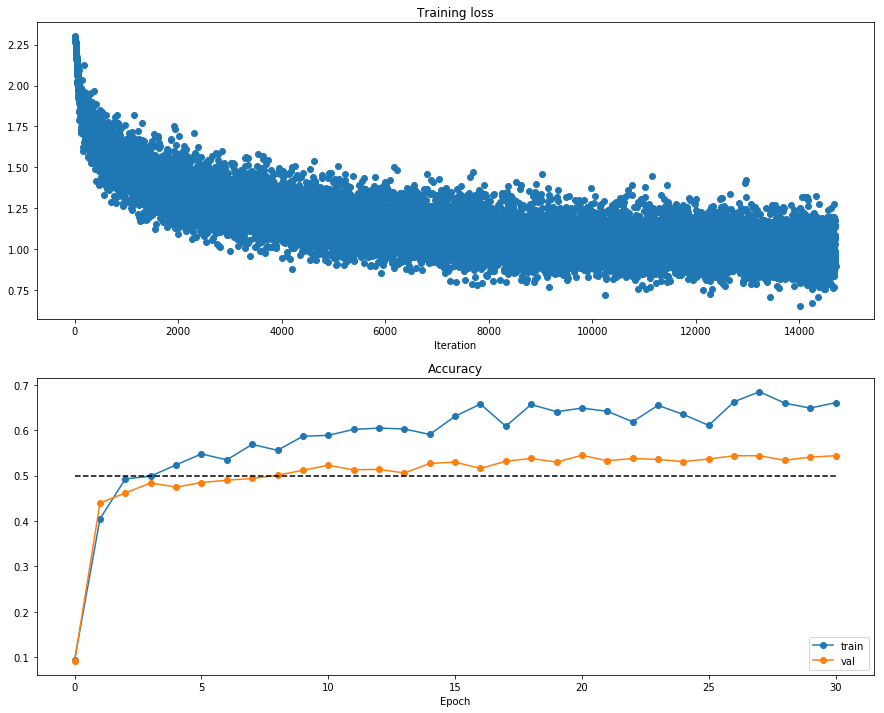

In [88]:
# Run this cell to visualize training loss and train / val accuracy, and save the log file of the
# experiment for submission.

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

solver.record_histories_as_npz('submission_logs/train_2layer_fc.npz')

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `deeplearning/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

In [92]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [95]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print ('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                              reg=reg, weight_scale=5e-2, dtype=np.float64)

    loss, grads = model.loss(X, y)
    print ('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.307230465949398
W1 relative error: 1.57e-07
W2 relative error: 7.09e-07
W3 relative error: 1.47e-07
b1 relative error: 2.19e-08
b2 relative error: 1.48e-09
b3 relative error: 7.43e-11
Running check with reg =  3.14
Initial loss:  5.618058493130896
W1 relative error: 2.03e-07
W2 relative error: 1.32e-07
W3 relative error: 9.92e-09
b1 relative error: 1.49e-08
b2 relative error: 8.96e-09
b3 relative error: 2.11e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.287117
(Epoch 0 / 20) train acc: 0.280000; val_acc: 0.118000
(Epoch 1 / 20) train acc: 0.400000; val_acc: 0.129000
(Epoch 2 / 20) train acc: 0.380000; val_acc: 0.155000
(Epoch 3 / 20) train acc: 0.560000; val_acc: 0.146000
(Epoch 4 / 20) train acc: 0.500000; val_acc: 0.168000
(Epoch 5 / 20) train acc: 0.640000; val_acc: 0.167000
(Iteration 11 / 40) loss: 1.111450
(Epoch 6 / 20) train acc: 0.820000; val_acc: 0.180000
(Epoch 7 / 20) train acc: 0.780000; val_acc: 0.171000
(Epoch 8 / 20) train acc: 0.900000; val_acc: 0.185000
(Epoch 9 / 20) train acc: 0.900000; val_acc: 0.167000
(Epoch 10 / 20) train acc: 0.500000; val_acc: 0.164000
(Iteration 21 / 40) loss: 1.057728
(Epoch 11 / 20) train acc: 0.740000; val_acc: 0.158000
(Epoch 12 / 20) train acc: 0.900000; val_acc: 0.167000
(Epoch 13 / 20) train acc: 0.940000; val_acc: 0.161000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.176000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.176000
(Iteration 31 / 40) loss: 

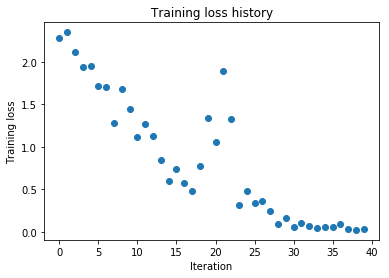

In [101]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

############################################################################
# TODO: Tune these parameters to get 100% train accuracy within 20 epochs. #
############################################################################
weight_scale = 1e-2
learning_rate = 1e-2
############################################################################
#                             END OF YOUR CODE                             #
############################################################################

model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

solver.record_histories_as_npz('submission_logs/overfit_3layer_fc.npz')

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 101.178451
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.122000
(Epoch 1 / 20) train acc: 0.300000; val_acc: 0.107000
(Epoch 2 / 20) train acc: 0.400000; val_acc: 0.104000
(Epoch 3 / 20) train acc: 0.520000; val_acc: 0.113000
(Epoch 4 / 20) train acc: 0.640000; val_acc: 0.125000
(Epoch 5 / 20) train acc: 0.840000; val_acc: 0.131000
(Iteration 11 / 40) loss: 5.111635
(Epoch 6 / 20) train acc: 0.880000; val_acc: 0.141000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.138000
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.143000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.142000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.139000
(Iteration 21 / 40) loss: 0.000024
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.139000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.141000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.141000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.141000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.141000
(Iteration 31 / 40) loss

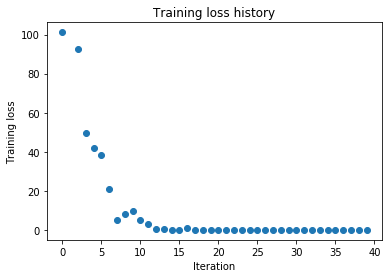

In [109]:
## TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

############################################################################
# TODO: Tune these parameters to get 100% train accuracy within 20 epochs. #
############################################################################
learning_rate = 1e-3
weight_scale = 1e-1
############################################################################
#                             END OF YOUR CODE                             #
############################################################################

model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

solver.record_histories_as_npz('submission_logs/overfit_5layer_fc.npz')

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:

TODO: reexamine this

The 5-layer network is relatively more difficult to train because our network is more expressive. In the case when our data has relatively small dimension (32x32x3), model with more layers can be too powerful for our task. I realized that I either underfit a lot or overfit a lot. It is harder to find the sweet spot.


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `deeplearning/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [112]:
from deeplearning.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(0.5, 1.5, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-1, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
 [-0.504,      -0.45805263, -0.41210526, -0.36615789, -0.32021053],
 [-0.27426316, -0.22831579, -0.18236842, -0.13642105, -0.09047368],
 [-0.04452632,  0.00142105,  0.04736842,  0.09331579,  0.13926316],
 [ 0.18521053,  0.23115789,  0.27710526,  0.32305263,  0.369     ]])

expected_velocity = np.asarray([
 [1.04,       1.10684211, 1.17368421, 1.24052632, 1.30736842],
 [1.37421053, 1.44105263, 1.50789474, 1.57473684, 1.64157895],
 [1.70842105, 1.77526316, 1.84210526, 1.90894737, 1.97578947],
 [2.04263158, 2.10947368, 2.17631579, 2.24315789, 2.31      ]])

print ('next_w error: ', rel_error(next_w, expected_next_w))
print ('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  9.259267785377383e-07
velocity error:  2.1398003469119033e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge a bit faster.

running with  sgd
(Iteration 1 / 200) loss: 2.463839
(Epoch 0 / 5) train acc: 0.106000; val_acc: 0.116000
(Iteration 11 / 200) loss: 2.236906
(Iteration 21 / 200) loss: 2.109752
(Iteration 31 / 200) loss: 2.061399
(Epoch 1 / 5) train acc: 0.283000; val_acc: 0.236000
(Iteration 41 / 200) loss: 2.007355
(Iteration 51 / 200) loss: 1.896054
(Iteration 61 / 200) loss: 1.968107
(Iteration 71 / 200) loss: 2.000546
(Epoch 2 / 5) train acc: 0.318000; val_acc: 0.277000
(Iteration 81 / 200) loss: 1.810222
(Iteration 91 / 200) loss: 1.879341
(Iteration 101 / 200) loss: 1.935241
(Iteration 111 / 200) loss: 1.800546
(Epoch 3 / 5) train acc: 0.358000; val_acc: 0.289000
(Iteration 121 / 200) loss: 1.832992
(Iteration 131 / 200) loss: 1.729009
(Iteration 141 / 200) loss: 1.752832
(Iteration 151 / 200) loss: 1.506908
(Epoch 4 / 5) train acc: 0.385000; val_acc: 0.313000
(Iteration 161 / 200) loss: 1.703749
(Iteration 171 / 200) loss: 1.641933
(Iteration 181 / 200) loss: 1.626257
(Iteration 191 / 200) los

/Users/princewang/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


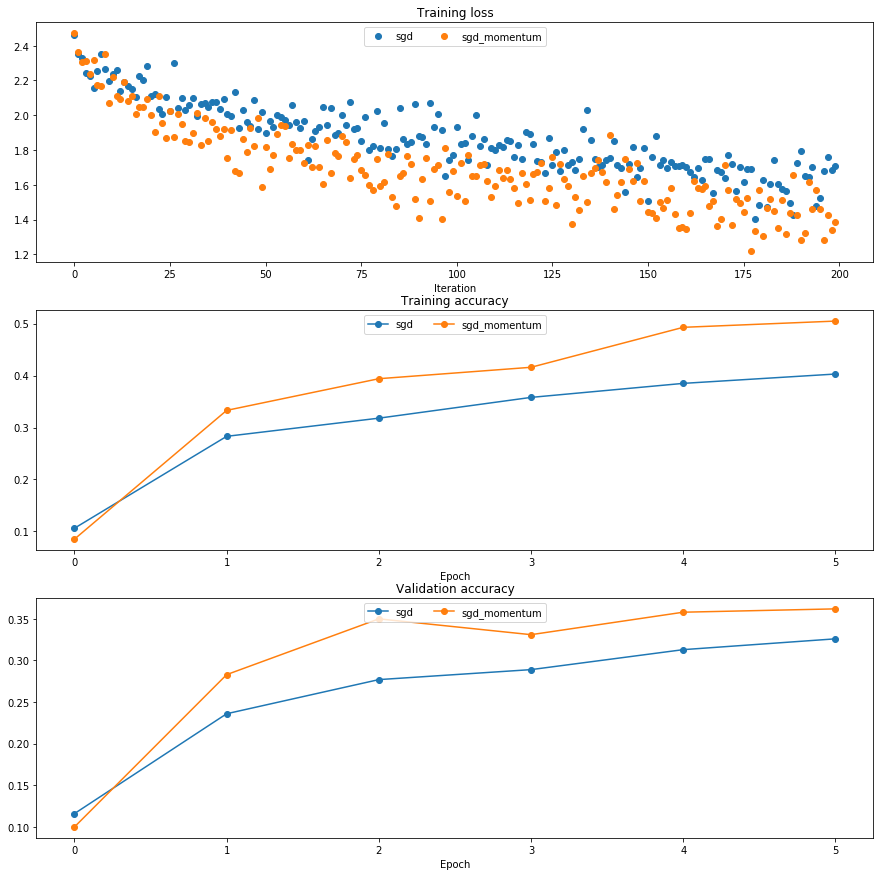

In [113]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print ('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    solver.record_histories_as_npz("submission_logs/optimizer_experiment_{}".format(update_rule))
    print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `deeplearning/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [115]:
# Test RMSProp implementation; you should see errors less than 1e-7.
from deeplearning.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print ('next_w error: ', rel_error(expected_next_w, next_w))
print ('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [117]:
# Test Adam implementation; you should see errors around 1e-7 or less.
from deeplearning.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])
expected_t = 6

print ('next_w error: ', rel_error(expected_next_w, next_w))
print ('v error: ', rel_error(expected_v, config['v']))
print ('m error: ', rel_error(expected_m, config['m']))
print ('t error: ', rel_error(expected_t, config['t']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09
t error:  0.0


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules. As a sanity check, you should see that RMSProp and Adam typically obtain at least 45% training accuracy within 5 epochs.

running with  adam
(Iteration 1 / 200) loss: 2.678284
(Epoch 0 / 5) train acc: 0.146000; val_acc: 0.135000
(Iteration 11 / 200) loss: 2.046118
(Iteration 21 / 200) loss: 1.917962
(Iteration 31 / 200) loss: 1.633795
(Epoch 1 / 5) train acc: 0.380000; val_acc: 0.328000
(Iteration 41 / 200) loss: 1.736273
(Iteration 51 / 200) loss: 1.709275
(Iteration 61 / 200) loss: 1.673251
(Iteration 71 / 200) loss: 1.632860
(Epoch 2 / 5) train acc: 0.460000; val_acc: 0.347000
(Iteration 81 / 200) loss: 1.627332
(Iteration 91 / 200) loss: 1.319246
(Iteration 101 / 200) loss: 1.489752
(Iteration 111 / 200) loss: 1.468669
(Epoch 3 / 5) train acc: 0.455000; val_acc: 0.339000
(Iteration 121 / 200) loss: 1.492096
(Iteration 131 / 200) loss: 1.587858
(Iteration 141 / 200) loss: 1.324863
(Iteration 151 / 200) loss: 1.380894
(Epoch 4 / 5) train acc: 0.541000; val_acc: 0.342000
(Iteration 161 / 200) loss: 1.234648
(Iteration 171 / 200) loss: 1.445551
(Iteration 181 / 200) loss: 1.424113
(Iteration 191 / 200) lo

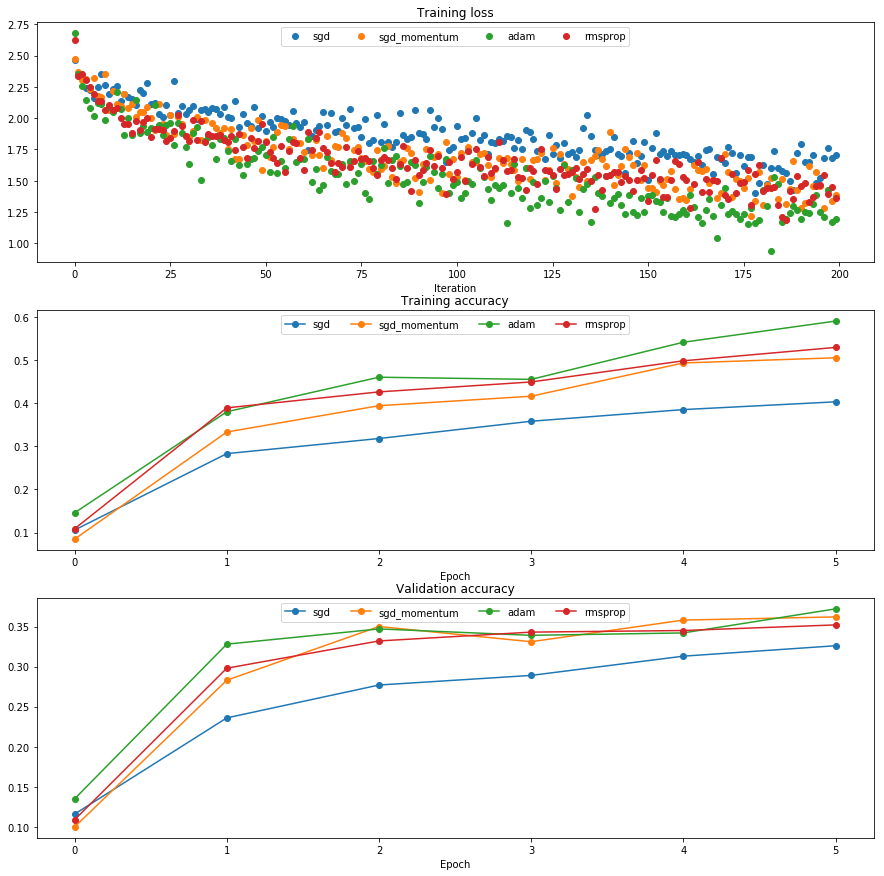

In [118]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print ('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    solver.record_histories_as_npz("submission_logs/optimizer_experiment_{}".format(update_rule))
    print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable and the solver used in the `best_solver` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [119]:
import time

In [132]:
best_model = None
best_solver = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch normalization and dropout useful. Store your best model in the    #
# best_model variable and the solver used to train it in the best_solver       #
# variable.                                                                    #
################################################################################

#search by learning rates
#search by update rules
#search by number of layers

best_acc = 0

hidden_layer_size = [50, 100, 200, 400]
number_of_layers = [5,6]
learning_rates = [1e-2, 1e-3, 1e-4]
epoch = 5
update_rules = ['adam', 'rmsprop', 'sgd_momentum']

# hidden_layer_size = [100]
# number_of_layers = [5]
# learning_rates = [1e-3]
# epoch = 5
# update_rules = ['adam']

training_data = {
  'X_train': data['X_train'][:],
  'y_train': data['y_train'][:],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


for update_rule in update_rules:
    for number_of_layer in number_of_layers:
            for hidden_size in hidden_layer_size:
                hidden_dim_size = [hidden_size for i in range(number_of_layer)]
                for lr in learning_rates:
                    before_time = time.time()
                    model = FullyConnectedNet(hidden_dim_size, weight_scale=5e-2)
                    
                    solver = Solver(model, training_data, num_epochs=epoch, batch_size=100
                                    , update_rule=update_rule, 
                                    optim_config={'learning_rate': lr}, verbose=False)
                    solver.train()
                    
                    print("elapsed training time: {}".format(time.time() - before_time))
                    
                    solver.record_histories_as_npz("submission_logs/model_{}_{}_{}_{}".format(update_rule
                                                                                           , number_of_layer,
                                                                                          hidden_size,
                                                                                          lr))
                    val_acc = solver.check_accuracy(training_data['X_val'], training_data['y_val'])
                    
                    if val_acc > best_acc:
                        best_model = model
                        best_solver = solver
                        best_acc = val_acc
                        print("current best param: lr:{}_hidden:{}_numlayers:{}_updaterule:{}".format(lr, hidden_size, number_of_layer, update_rule))
                        print("current best acc: {}".format(val_acc))
                    

                    
                    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

elapsed training time: 12.751192808151245
current best param: lr:0.01_hidden:50_numlayers:5_updaterule:adam
current best acc: 0.28
elapsed training time: 9.389086961746216
current best param: lr:0.001_hidden:50_numlayers:5_updaterule:adam
current best acc: 0.495
elapsed training time: 8.952858924865723
elapsed training time: 19.744771242141724
elapsed training time: 17.045652151107788
current best param: lr:0.001_hidden:100_numlayers:5_updaterule:adam
current best acc: 0.496
elapsed training time: 16.850877285003662
elapsed training time: 62.87553572654724
elapsed training time: 42.81476807594299
elapsed training time: 65.63759779930115
elapsed training time: 197.39815187454224
elapsed training time: 114.11598372459412
elapsed training time: 103.51930022239685
elapsed training time: 13.94323205947876
elapsed training time: 10.533891201019287
elapsed training time: 10.69170594215393
elapsed training time: 27.146876096725464
elapsed training time: 23.817130088806152
elapsed training time

/Users/princewang/Documents/UCB_SP21/CS182/hw1/deeplearning/layers.py:31: RuntimeWarning: invalid value encountered in matmul
  out = np.add(np.matmul(x_flat, w), b)


elapsed training time: 48.913026094436646
elapsed training time: 61.62488603591919
elapsed training time: 48.43565225601196
elapsed training time: 8.060183048248291
elapsed training time: 9.425307989120483
elapsed training time: 9.258800983428955
elapsed training time: 15.555261850357056
elapsed training time: 15.599873781204224
elapsed training time: 15.52990174293518
elapsed training time: 27.90282893180847
current best param: lr:0.01_hidden:200_numlayers:6_updaterule:sgd_momentum
current best acc: 0.506
elapsed training time: 26.828212022781372
elapsed training time: 27.99708390235901
elapsed training time: 56.38181686401367
elapsed training time: 63.784181118011475
elapsed training time: 57.686126947402954


In [134]:
best_model = None
best_solver = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch normalization and dropout useful. Store your best model in the    #
# best_model variable and the solver used to train it in the best_solver       #
# variable.                                                                    #
################################################################################

#search by learning rates
#search by update rules
#search by number of layers

best_acc = 0

hidden_layer_size = [200, 400]
number_of_layers = [5,6]
learning_rates = [1e-3, 1e-4]
epoch = 30
update_rules = ['adam']

# hidden_layer_size = [100]
# number_of_layers = [5]
# learning_rates = [1e-3]
# epoch = 5
# update_rules = ['adam']

training_data = {
  'X_train': data['X_train'][:],
  'y_train': data['y_train'][:],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


for update_rule in update_rules:
    for number_of_layer in number_of_layers:
            for hidden_size in hidden_layer_size:
                hidden_dim_size = [hidden_size for i in range(number_of_layer)]
                for lr in learning_rates:
                    before_time = time.time()
                    model = FullyConnectedNet(hidden_dim_size, weight_scale=5e-2)
                    
                    solver = Solver(model, training_data, num_epochs=epoch, batch_size=100
                                    , update_rule=update_rule, 
                                    optim_config={'learning_rate': lr}, verbose=True)
                    solver.train()
                    
                    print("elapsed training time: {}".format(time.time() - before_time))
                    
                    solver.record_histories_as_npz("submission_logs/model_{}_{}_{}_{}".format(update_rule
                                                                                           , number_of_layer,
                                                                                          hidden_size,
                                                                                          lr))
                    val_acc = solver.check_accuracy(training_data['X_val'], training_data['y_val'])
                    
                    if val_acc > best_acc:
                        best_model = model
                        best_solver = solver
                        best_acc = val_acc
                        print("current best param: lr:{}_hidden:{}_numlayers:{}_updaterule:{}".format(lr, hidden_size, number_of_layer, update_rule))
                        print("current best acc: {}".format(val_acc))
                    

                    
                    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 14700) loss: 5.506572
(Epoch 0 / 30) train acc: 0.107000; val_acc: 0.087000
(Iteration 11 / 14700) loss: 2.477893
(Iteration 21 / 14700) loss: 2.545432
(Iteration 31 / 14700) loss: 2.155324
(Iteration 41 / 14700) loss: 1.875914
(Iteration 51 / 14700) loss: 1.983470
(Iteration 61 / 14700) loss: 1.961472
(Iteration 71 / 14700) loss: 1.828011
(Iteration 81 / 14700) loss: 1.927133
(Iteration 91 / 14700) loss: 1.973913
(Iteration 101 / 14700) loss: 1.995725
(Iteration 111 / 14700) loss: 1.739798
(Iteration 121 / 14700) loss: 1.780338
(Iteration 131 / 14700) loss: 1.872425
(Iteration 141 / 14700) loss: 1.695482
(Iteration 151 / 14700) loss: 1.779619
(Iteration 161 / 14700) loss: 1.678964
(Iteration 171 / 14700) loss: 1.794411
(Iteration 181 / 14700) loss: 1.737183
(Iteration 191 / 14700) loss: 1.911089
(Iteration 201 / 14700) loss: 1.856710
(Iteration 211 / 14700) loss: 1.974892
(Iteration 221 / 14700) loss: 1.789022
(Iteration 231 / 14700) loss: 1.743608
(Iteration 241 / 1470

(Iteration 2011 / 14700) loss: 1.217111
(Iteration 2021 / 14700) loss: 1.202980
(Iteration 2031 / 14700) loss: 1.247107
(Iteration 2041 / 14700) loss: 1.234269
(Iteration 2051 / 14700) loss: 1.153587
(Iteration 2061 / 14700) loss: 1.471094
(Iteration 2071 / 14700) loss: 1.112994
(Iteration 2081 / 14700) loss: 1.493199
(Iteration 2091 / 14700) loss: 1.312039
(Iteration 2101 / 14700) loss: 1.242146
(Iteration 2111 / 14700) loss: 1.145069
(Iteration 2121 / 14700) loss: 1.308082
(Iteration 2131 / 14700) loss: 1.280966
(Iteration 2141 / 14700) loss: 1.444161
(Iteration 2151 / 14700) loss: 1.295808
(Iteration 2161 / 14700) loss: 1.406724
(Iteration 2171 / 14700) loss: 1.287828
(Iteration 2181 / 14700) loss: 1.417556
(Iteration 2191 / 14700) loss: 1.145401
(Iteration 2201 / 14700) loss: 1.195083
(Iteration 2211 / 14700) loss: 1.457573
(Iteration 2221 / 14700) loss: 1.247174
(Iteration 2231 / 14700) loss: 1.207504
(Iteration 2241 / 14700) loss: 1.197218
(Iteration 2251 / 14700) loss: 1.477820


(Iteration 4021 / 14700) loss: 1.101798
(Iteration 4031 / 14700) loss: 1.214030
(Iteration 4041 / 14700) loss: 1.061379
(Iteration 4051 / 14700) loss: 1.164137
(Iteration 4061 / 14700) loss: 1.082892
(Iteration 4071 / 14700) loss: 1.115868
(Iteration 4081 / 14700) loss: 1.068334
(Iteration 4091 / 14700) loss: 1.027736
(Iteration 4101 / 14700) loss: 1.075621
(Iteration 4111 / 14700) loss: 1.276753
(Iteration 4121 / 14700) loss: 1.110870
(Iteration 4131 / 14700) loss: 1.078868
(Iteration 4141 / 14700) loss: 1.168952
(Iteration 4151 / 14700) loss: 1.157502
(Iteration 4161 / 14700) loss: 1.290170
(Iteration 4171 / 14700) loss: 1.150939
(Iteration 4181 / 14700) loss: 1.167291
(Iteration 4191 / 14700) loss: 1.144331
(Iteration 4201 / 14700) loss: 1.119264
(Iteration 4211 / 14700) loss: 1.219619
(Iteration 4221 / 14700) loss: 0.928129
(Iteration 4231 / 14700) loss: 1.150573
(Iteration 4241 / 14700) loss: 1.096139
(Iteration 4251 / 14700) loss: 1.063942
(Iteration 4261 / 14700) loss: 1.163143


(Iteration 6021 / 14700) loss: 1.162393
(Iteration 6031 / 14700) loss: 1.122034
(Iteration 6041 / 14700) loss: 1.028109
(Iteration 6051 / 14700) loss: 1.183394
(Iteration 6061 / 14700) loss: 0.844402
(Iteration 6071 / 14700) loss: 1.148065
(Iteration 6081 / 14700) loss: 0.849870
(Iteration 6091 / 14700) loss: 1.015536
(Iteration 6101 / 14700) loss: 1.036461
(Iteration 6111 / 14700) loss: 1.082465
(Iteration 6121 / 14700) loss: 1.048371
(Iteration 6131 / 14700) loss: 0.952217
(Iteration 6141 / 14700) loss: 0.873658
(Iteration 6151 / 14700) loss: 0.891291
(Iteration 6161 / 14700) loss: 0.892557
(Iteration 6171 / 14700) loss: 0.978674
(Iteration 6181 / 14700) loss: 1.113291
(Iteration 6191 / 14700) loss: 1.170388
(Iteration 6201 / 14700) loss: 0.978698
(Iteration 6211 / 14700) loss: 1.039519
(Iteration 6221 / 14700) loss: 1.189265
(Iteration 6231 / 14700) loss: 1.100492
(Iteration 6241 / 14700) loss: 1.156941
(Iteration 6251 / 14700) loss: 1.030263
(Iteration 6261 / 14700) loss: 0.866982


(Iteration 8021 / 14700) loss: 0.719018
(Iteration 8031 / 14700) loss: 0.910704
(Iteration 8041 / 14700) loss: 0.766359
(Iteration 8051 / 14700) loss: 0.857880
(Iteration 8061 / 14700) loss: 0.928301
(Iteration 8071 / 14700) loss: 1.044106
(Iteration 8081 / 14700) loss: 1.228272
(Iteration 8091 / 14700) loss: 1.030415
(Iteration 8101 / 14700) loss: 0.861868
(Iteration 8111 / 14700) loss: 0.755398
(Iteration 8121 / 14700) loss: 0.905666
(Iteration 8131 / 14700) loss: 0.913596
(Iteration 8141 / 14700) loss: 0.795915
(Iteration 8151 / 14700) loss: 1.002251
(Iteration 8161 / 14700) loss: 1.050679
(Iteration 8171 / 14700) loss: 0.948487
(Iteration 8181 / 14700) loss: 1.115037
(Iteration 8191 / 14700) loss: 0.786687
(Iteration 8201 / 14700) loss: 0.878110
(Iteration 8211 / 14700) loss: 0.737288
(Iteration 8221 / 14700) loss: 0.889855
(Iteration 8231 / 14700) loss: 0.955432
(Iteration 8241 / 14700) loss: 0.712643
(Iteration 8251 / 14700) loss: 0.975797
(Iteration 8261 / 14700) loss: 0.880697


(Iteration 10031 / 14700) loss: 0.872877
(Iteration 10041 / 14700) loss: 0.715861
(Iteration 10051 / 14700) loss: 0.669967
(Iteration 10061 / 14700) loss: 0.725496
(Iteration 10071 / 14700) loss: 0.704411
(Iteration 10081 / 14700) loss: 0.688461
(Iteration 10091 / 14700) loss: 0.618339
(Iteration 10101 / 14700) loss: 0.842993
(Iteration 10111 / 14700) loss: 0.753976
(Iteration 10121 / 14700) loss: 0.711152
(Iteration 10131 / 14700) loss: 0.703574
(Iteration 10141 / 14700) loss: 0.722628
(Iteration 10151 / 14700) loss: 0.642364
(Iteration 10161 / 14700) loss: 0.768453
(Iteration 10171 / 14700) loss: 0.703069
(Iteration 10181 / 14700) loss: 0.824139
(Iteration 10191 / 14700) loss: 0.761272
(Iteration 10201 / 14700) loss: 0.903793
(Iteration 10211 / 14700) loss: 0.933903
(Iteration 10221 / 14700) loss: 0.649359
(Iteration 10231 / 14700) loss: 0.739766
(Iteration 10241 / 14700) loss: 0.757215
(Iteration 10251 / 14700) loss: 0.621476
(Iteration 10261 / 14700) loss: 0.592856
(Iteration 10271

(Iteration 11981 / 14700) loss: 0.587170
(Iteration 11991 / 14700) loss: 0.534204
(Iteration 12001 / 14700) loss: 0.691229
(Iteration 12011 / 14700) loss: 0.427241
(Iteration 12021 / 14700) loss: 0.858005
(Iteration 12031 / 14700) loss: 0.649581
(Iteration 12041 / 14700) loss: 0.505313
(Iteration 12051 / 14700) loss: 0.728700
(Iteration 12061 / 14700) loss: 0.699305
(Iteration 12071 / 14700) loss: 0.825683
(Iteration 12081 / 14700) loss: 0.565379
(Iteration 12091 / 14700) loss: 0.997037
(Iteration 12101 / 14700) loss: 0.723579
(Iteration 12111 / 14700) loss: 0.561460
(Iteration 12121 / 14700) loss: 0.561695
(Iteration 12131 / 14700) loss: 0.738631
(Iteration 12141 / 14700) loss: 0.565416
(Iteration 12151 / 14700) loss: 0.790918
(Iteration 12161 / 14700) loss: 0.584636
(Iteration 12171 / 14700) loss: 0.611089
(Iteration 12181 / 14700) loss: 0.554211
(Iteration 12191 / 14700) loss: 0.684939
(Iteration 12201 / 14700) loss: 0.653197
(Iteration 12211 / 14700) loss: 0.810410
(Iteration 12221

(Iteration 13931 / 14700) loss: 0.491969
(Iteration 13941 / 14700) loss: 0.797920
(Iteration 13951 / 14700) loss: 0.541234
(Iteration 13961 / 14700) loss: 0.659916
(Iteration 13971 / 14700) loss: 0.560308
(Iteration 13981 / 14700) loss: 0.636316
(Iteration 13991 / 14700) loss: 0.445579
(Iteration 14001 / 14700) loss: 0.573312
(Iteration 14011 / 14700) loss: 0.585648
(Iteration 14021 / 14700) loss: 0.701605
(Iteration 14031 / 14700) loss: 0.735415
(Iteration 14041 / 14700) loss: 0.512976
(Iteration 14051 / 14700) loss: 0.698499
(Iteration 14061 / 14700) loss: 0.507028
(Iteration 14071 / 14700) loss: 0.560792
(Iteration 14081 / 14700) loss: 0.558723
(Iteration 14091 / 14700) loss: 0.814609
(Iteration 14101 / 14700) loss: 0.620194
(Iteration 14111 / 14700) loss: 0.533304
(Iteration 14121 / 14700) loss: 0.586457
(Iteration 14131 / 14700) loss: 0.654415
(Iteration 14141 / 14700) loss: 0.747411
(Iteration 14151 / 14700) loss: 0.632113
(Iteration 14161 / 14700) loss: 0.682401
(Iteration 14171

(Iteration 1191 / 14700) loss: 1.436346
(Iteration 1201 / 14700) loss: 1.526655
(Iteration 1211 / 14700) loss: 1.327927
(Iteration 1221 / 14700) loss: 1.428183
(Iteration 1231 / 14700) loss: 1.405431
(Iteration 1241 / 14700) loss: 1.405975
(Iteration 1251 / 14700) loss: 1.543972
(Iteration 1261 / 14700) loss: 1.290603
(Iteration 1271 / 14700) loss: 1.506624
(Iteration 1281 / 14700) loss: 1.569245
(Iteration 1291 / 14700) loss: 1.482402
(Iteration 1301 / 14700) loss: 1.557403
(Iteration 1311 / 14700) loss: 1.449956
(Iteration 1321 / 14700) loss: 1.401554
(Iteration 1331 / 14700) loss: 1.568977
(Iteration 1341 / 14700) loss: 1.418837
(Iteration 1351 / 14700) loss: 1.727340
(Iteration 1361 / 14700) loss: 1.550561
(Iteration 1371 / 14700) loss: 1.392175
(Iteration 1381 / 14700) loss: 1.525563
(Iteration 1391 / 14700) loss: 1.341195
(Iteration 1401 / 14700) loss: 1.388168
(Iteration 1411 / 14700) loss: 1.613983
(Iteration 1421 / 14700) loss: 1.538074
(Iteration 1431 / 14700) loss: 1.369088


(Iteration 3201 / 14700) loss: 1.228866
(Iteration 3211 / 14700) loss: 0.999703
(Iteration 3221 / 14700) loss: 0.940082
(Iteration 3231 / 14700) loss: 0.923803
(Iteration 3241 / 14700) loss: 1.029989
(Iteration 3251 / 14700) loss: 1.051651
(Iteration 3261 / 14700) loss: 1.074726
(Iteration 3271 / 14700) loss: 1.229851
(Iteration 3281 / 14700) loss: 1.115056
(Iteration 3291 / 14700) loss: 1.303223
(Iteration 3301 / 14700) loss: 1.159503
(Iteration 3311 / 14700) loss: 1.151364
(Iteration 3321 / 14700) loss: 1.154992
(Iteration 3331 / 14700) loss: 1.036459
(Iteration 3341 / 14700) loss: 0.974314
(Iteration 3351 / 14700) loss: 1.025925
(Iteration 3361 / 14700) loss: 0.965162
(Iteration 3371 / 14700) loss: 1.190471
(Iteration 3381 / 14700) loss: 1.114113
(Iteration 3391 / 14700) loss: 0.968174
(Iteration 3401 / 14700) loss: 1.069768
(Iteration 3411 / 14700) loss: 1.103123
(Iteration 3421 / 14700) loss: 1.197532
(Epoch 7 / 30) train acc: 0.635000; val_acc: 0.457000
(Iteration 3431 / 14700) l

(Iteration 5201 / 14700) loss: 0.812810
(Iteration 5211 / 14700) loss: 0.911197
(Iteration 5221 / 14700) loss: 0.973313
(Iteration 5231 / 14700) loss: 0.930705
(Iteration 5241 / 14700) loss: 0.902917
(Iteration 5251 / 14700) loss: 0.831580
(Iteration 5261 / 14700) loss: 0.905908
(Iteration 5271 / 14700) loss: 0.885688
(Iteration 5281 / 14700) loss: 0.880035
(Iteration 5291 / 14700) loss: 0.904009
(Iteration 5301 / 14700) loss: 0.792559
(Iteration 5311 / 14700) loss: 0.819276
(Iteration 5321 / 14700) loss: 0.964976
(Iteration 5331 / 14700) loss: 0.898282
(Iteration 5341 / 14700) loss: 0.808323
(Iteration 5351 / 14700) loss: 0.930190
(Iteration 5361 / 14700) loss: 0.836586
(Iteration 5371 / 14700) loss: 0.642346
(Iteration 5381 / 14700) loss: 0.725495
(Epoch 11 / 30) train acc: 0.729000; val_acc: 0.468000
(Iteration 5391 / 14700) loss: 0.903889
(Iteration 5401 / 14700) loss: 1.096961
(Iteration 5411 / 14700) loss: 0.735828
(Iteration 5421 / 14700) loss: 0.882216
(Iteration 5431 / 14700) 

(Iteration 7211 / 14700) loss: 0.664180
(Iteration 7221 / 14700) loss: 0.671425
(Iteration 7231 / 14700) loss: 0.591348
(Iteration 7241 / 14700) loss: 0.625700
(Iteration 7251 / 14700) loss: 0.652966
(Iteration 7261 / 14700) loss: 0.594390
(Iteration 7271 / 14700) loss: 0.594599
(Iteration 7281 / 14700) loss: 0.626369
(Iteration 7291 / 14700) loss: 0.723401
(Iteration 7301 / 14700) loss: 0.527201
(Iteration 7311 / 14700) loss: 0.799861
(Iteration 7321 / 14700) loss: 0.596302
(Iteration 7331 / 14700) loss: 0.511632
(Iteration 7341 / 14700) loss: 0.573296
(Epoch 15 / 30) train acc: 0.819000; val_acc: 0.461000
(Iteration 7351 / 14700) loss: 0.515852
(Iteration 7361 / 14700) loss: 0.535929
(Iteration 7371 / 14700) loss: 0.514335
(Iteration 7381 / 14700) loss: 0.554840
(Iteration 7391 / 14700) loss: 0.553296
(Iteration 7401 / 14700) loss: 0.639532
(Iteration 7411 / 14700) loss: 0.685501
(Iteration 7421 / 14700) loss: 0.710554
(Iteration 7431 / 14700) loss: 0.537129
(Iteration 7441 / 14700) 

(Iteration 9211 / 14700) loss: 0.584506
(Iteration 9221 / 14700) loss: 0.384672
(Iteration 9231 / 14700) loss: 0.448147
(Iteration 9241 / 14700) loss: 0.288051
(Iteration 9251 / 14700) loss: 0.591117
(Iteration 9261 / 14700) loss: 0.500239
(Iteration 9271 / 14700) loss: 0.335042
(Iteration 9281 / 14700) loss: 0.369575
(Iteration 9291 / 14700) loss: 0.475709
(Iteration 9301 / 14700) loss: 0.419219
(Epoch 19 / 30) train acc: 0.859000; val_acc: 0.473000
(Iteration 9311 / 14700) loss: 0.303152
(Iteration 9321 / 14700) loss: 0.478963
(Iteration 9331 / 14700) loss: 0.366409
(Iteration 9341 / 14700) loss: 0.356460
(Iteration 9351 / 14700) loss: 0.501913
(Iteration 9361 / 14700) loss: 0.404048
(Iteration 9371 / 14700) loss: 0.500648
(Iteration 9381 / 14700) loss: 0.360825
(Iteration 9391 / 14700) loss: 0.304261
(Iteration 9401 / 14700) loss: 0.390652
(Iteration 9411 / 14700) loss: 0.423407
(Iteration 9421 / 14700) loss: 0.431528
(Iteration 9431 / 14700) loss: 0.217425
(Iteration 9441 / 14700) 

(Iteration 11181 / 14700) loss: 0.267898
(Iteration 11191 / 14700) loss: 0.273280
(Iteration 11201 / 14700) loss: 0.195807
(Iteration 11211 / 14700) loss: 0.274281
(Iteration 11221 / 14700) loss: 0.246932
(Iteration 11231 / 14700) loss: 0.323907
(Iteration 11241 / 14700) loss: 0.228131
(Iteration 11251 / 14700) loss: 0.261354
(Iteration 11261 / 14700) loss: 0.335317
(Epoch 23 / 30) train acc: 0.927000; val_acc: 0.470000
(Iteration 11271 / 14700) loss: 0.323630
(Iteration 11281 / 14700) loss: 0.402382
(Iteration 11291 / 14700) loss: 0.323944
(Iteration 11301 / 14700) loss: 0.223301
(Iteration 11311 / 14700) loss: 0.273262
(Iteration 11321 / 14700) loss: 0.183646
(Iteration 11331 / 14700) loss: 0.364858
(Iteration 11341 / 14700) loss: 0.224490
(Iteration 11351 / 14700) loss: 0.220532
(Iteration 11361 / 14700) loss: 0.297631
(Iteration 11371 / 14700) loss: 0.276866
(Iteration 11381 / 14700) loss: 0.223973
(Iteration 11391 / 14700) loss: 0.245997
(Iteration 11401 / 14700) loss: 0.276919
(I

(Iteration 13131 / 14700) loss: 0.201492
(Iteration 13141 / 14700) loss: 0.222716
(Iteration 13151 / 14700) loss: 0.113564
(Iteration 13161 / 14700) loss: 0.263456
(Iteration 13171 / 14700) loss: 0.227487
(Iteration 13181 / 14700) loss: 0.301537
(Iteration 13191 / 14700) loss: 0.191801
(Iteration 13201 / 14700) loss: 0.265315
(Iteration 13211 / 14700) loss: 0.279899
(Iteration 13221 / 14700) loss: 0.230476
(Epoch 27 / 30) train acc: 0.943000; val_acc: 0.482000
(Iteration 13231 / 14700) loss: 0.447060
(Iteration 13241 / 14700) loss: 0.226461
(Iteration 13251 / 14700) loss: 0.165240
(Iteration 13261 / 14700) loss: 0.281447
(Iteration 13271 / 14700) loss: 0.199243
(Iteration 13281 / 14700) loss: 0.173303
(Iteration 13291 / 14700) loss: 0.313772
(Iteration 13301 / 14700) loss: 0.201813
(Iteration 13311 / 14700) loss: 0.205194
(Iteration 13321 / 14700) loss: 0.178479
(Iteration 13331 / 14700) loss: 0.144334
(Iteration 13341 / 14700) loss: 0.259631
(Iteration 13351 / 14700) loss: 0.219763
(I

(Iteration 381 / 14700) loss: 1.709784
(Iteration 391 / 14700) loss: 1.831874
(Iteration 401 / 14700) loss: 1.652818
(Iteration 411 / 14700) loss: 1.690915
(Iteration 421 / 14700) loss: 1.823955
(Iteration 431 / 14700) loss: 1.908427
(Iteration 441 / 14700) loss: 1.698955
(Iteration 451 / 14700) loss: 1.641345
(Iteration 461 / 14700) loss: 1.727402
(Iteration 471 / 14700) loss: 1.563591
(Iteration 481 / 14700) loss: 1.777505
(Epoch 1 / 30) train acc: 0.408000; val_acc: 0.388000
(Iteration 491 / 14700) loss: 1.510709
(Iteration 501 / 14700) loss: 1.533577
(Iteration 511 / 14700) loss: 1.600587
(Iteration 521 / 14700) loss: 1.689185
(Iteration 531 / 14700) loss: 1.873268
(Iteration 541 / 14700) loss: 1.829705
(Iteration 551 / 14700) loss: 1.457441
(Iteration 561 / 14700) loss: 1.827383
(Iteration 571 / 14700) loss: 1.695972
(Iteration 581 / 14700) loss: 1.546156
(Iteration 591 / 14700) loss: 1.611149
(Iteration 601 / 14700) loss: 1.816833
(Iteration 611 / 14700) loss: 1.488374
(Iteration

(Iteration 2391 / 14700) loss: 1.306843
(Iteration 2401 / 14700) loss: 1.318368
(Iteration 2411 / 14700) loss: 1.289097
(Iteration 2421 / 14700) loss: 1.358209
(Iteration 2431 / 14700) loss: 1.363729
(Iteration 2441 / 14700) loss: 1.340141
(Epoch 5 / 30) train acc: 0.563000; val_acc: 0.491000
(Iteration 2451 / 14700) loss: 1.097179
(Iteration 2461 / 14700) loss: 1.197306
(Iteration 2471 / 14700) loss: 1.311087
(Iteration 2481 / 14700) loss: 1.360941
(Iteration 2491 / 14700) loss: 1.236760
(Iteration 2501 / 14700) loss: 1.180199
(Iteration 2511 / 14700) loss: 1.397128
(Iteration 2521 / 14700) loss: 1.120837
(Iteration 2531 / 14700) loss: 1.073705
(Iteration 2541 / 14700) loss: 1.194993
(Iteration 2551 / 14700) loss: 1.434459
(Iteration 2561 / 14700) loss: 1.310264
(Iteration 2571 / 14700) loss: 1.360563
(Iteration 2581 / 14700) loss: 1.284419
(Iteration 2591 / 14700) loss: 1.469547
(Iteration 2601 / 14700) loss: 1.250432
(Iteration 2611 / 14700) loss: 1.254199
(Iteration 2621 / 14700) l

(Iteration 4391 / 14700) loss: 1.062273
(Iteration 4401 / 14700) loss: 1.117170
(Epoch 9 / 30) train acc: 0.631000; val_acc: 0.502000
(Iteration 4411 / 14700) loss: 1.152272
(Iteration 4421 / 14700) loss: 1.274421
(Iteration 4431 / 14700) loss: 1.231181
(Iteration 4441 / 14700) loss: 1.201589
(Iteration 4451 / 14700) loss: 1.065794
(Iteration 4461 / 14700) loss: 1.036709
(Iteration 4471 / 14700) loss: 1.122648
(Iteration 4481 / 14700) loss: 1.095736
(Iteration 4491 / 14700) loss: 1.050422
(Iteration 4501 / 14700) loss: 1.090459
(Iteration 4511 / 14700) loss: 1.230009
(Iteration 4521 / 14700) loss: 1.026792
(Iteration 4531 / 14700) loss: 1.348411
(Iteration 4541 / 14700) loss: 1.127977
(Iteration 4551 / 14700) loss: 1.131584
(Iteration 4561 / 14700) loss: 0.986243
(Iteration 4571 / 14700) loss: 1.026539
(Iteration 4581 / 14700) loss: 0.976731
(Iteration 4591 / 14700) loss: 1.129907
(Iteration 4601 / 14700) loss: 1.045978
(Iteration 4611 / 14700) loss: 1.160266
(Iteration 4621 / 14700) l

(Iteration 6381 / 14700) loss: 1.030982
(Iteration 6391 / 14700) loss: 0.880090
(Iteration 6401 / 14700) loss: 1.432780
(Iteration 6411 / 14700) loss: 1.105456
(Iteration 6421 / 14700) loss: 1.024409
(Iteration 6431 / 14700) loss: 1.057681
(Iteration 6441 / 14700) loss: 1.140947
(Iteration 6451 / 14700) loss: 0.766185
(Iteration 6461 / 14700) loss: 1.001304
(Iteration 6471 / 14700) loss: 0.925439
(Iteration 6481 / 14700) loss: 1.107605
(Iteration 6491 / 14700) loss: 1.020241
(Iteration 6501 / 14700) loss: 1.146190
(Iteration 6511 / 14700) loss: 1.016676
(Iteration 6521 / 14700) loss: 1.009746
(Iteration 6531 / 14700) loss: 1.054565
(Iteration 6541 / 14700) loss: 0.923152
(Iteration 6551 / 14700) loss: 1.121006
(Iteration 6561 / 14700) loss: 0.845918
(Iteration 6571 / 14700) loss: 1.035874
(Iteration 6581 / 14700) loss: 0.798099
(Iteration 6591 / 14700) loss: 0.940181
(Iteration 6601 / 14700) loss: 0.986678
(Iteration 6611 / 14700) loss: 0.973373
(Iteration 6621 / 14700) loss: 0.803686


(Iteration 8381 / 14700) loss: 0.762986
(Iteration 8391 / 14700) loss: 1.081075
(Iteration 8401 / 14700) loss: 0.736354
(Iteration 8411 / 14700) loss: 0.801003
(Iteration 8421 / 14700) loss: 0.971703
(Iteration 8431 / 14700) loss: 0.584127
(Iteration 8441 / 14700) loss: 0.738655
(Iteration 8451 / 14700) loss: 0.864219
(Iteration 8461 / 14700) loss: 0.866909
(Iteration 8471 / 14700) loss: 0.769368
(Iteration 8481 / 14700) loss: 1.012486
(Iteration 8491 / 14700) loss: 0.807145
(Iteration 8501 / 14700) loss: 0.834373
(Iteration 8511 / 14700) loss: 1.042226
(Iteration 8521 / 14700) loss: 0.819781
(Iteration 8531 / 14700) loss: 0.895421
(Iteration 8541 / 14700) loss: 1.000552
(Iteration 8551 / 14700) loss: 0.580733
(Iteration 8561 / 14700) loss: 0.887470
(Iteration 8571 / 14700) loss: 1.165168
(Iteration 8581 / 14700) loss: 0.903283
(Iteration 8591 / 14700) loss: 0.926544
(Iteration 8601 / 14700) loss: 0.915111
(Iteration 8611 / 14700) loss: 0.712234
(Iteration 8621 / 14700) loss: 0.855448


(Iteration 10371 / 14700) loss: 0.597235
(Iteration 10381 / 14700) loss: 0.699025
(Iteration 10391 / 14700) loss: 0.770198
(Iteration 10401 / 14700) loss: 0.553671
(Iteration 10411 / 14700) loss: 0.727015
(Iteration 10421 / 14700) loss: 0.634703
(Iteration 10431 / 14700) loss: 0.822151
(Iteration 10441 / 14700) loss: 0.696082
(Iteration 10451 / 14700) loss: 0.981793
(Iteration 10461 / 14700) loss: 0.568925
(Iteration 10471 / 14700) loss: 0.832535
(Iteration 10481 / 14700) loss: 0.616596
(Iteration 10491 / 14700) loss: 0.895310
(Iteration 10501 / 14700) loss: 0.652244
(Iteration 10511 / 14700) loss: 0.631363
(Iteration 10521 / 14700) loss: 0.908333
(Iteration 10531 / 14700) loss: 0.552610
(Iteration 10541 / 14700) loss: 0.854001
(Iteration 10551 / 14700) loss: 0.953399
(Iteration 10561 / 14700) loss: 0.823748
(Iteration 10571 / 14700) loss: 0.671287
(Iteration 10581 / 14700) loss: 0.533648
(Iteration 10591 / 14700) loss: 0.585773
(Iteration 10601 / 14700) loss: 0.814604
(Iteration 10611

(Iteration 12321 / 14700) loss: 0.532075
(Iteration 12331 / 14700) loss: 0.637323
(Iteration 12341 / 14700) loss: 0.552827
(Iteration 12351 / 14700) loss: 0.580052
(Iteration 12361 / 14700) loss: 0.561656
(Iteration 12371 / 14700) loss: 0.661208
(Iteration 12381 / 14700) loss: 0.376578
(Iteration 12391 / 14700) loss: 0.760750
(Iteration 12401 / 14700) loss: 0.673931
(Iteration 12411 / 14700) loss: 0.431448
(Iteration 12421 / 14700) loss: 0.459780
(Iteration 12431 / 14700) loss: 0.442340
(Iteration 12441 / 14700) loss: 0.775107
(Iteration 12451 / 14700) loss: 0.655348
(Iteration 12461 / 14700) loss: 0.558775
(Iteration 12471 / 14700) loss: 0.530840
(Iteration 12481 / 14700) loss: 0.801592
(Iteration 12491 / 14700) loss: 0.659570
(Iteration 12501 / 14700) loss: 0.518102
(Iteration 12511 / 14700) loss: 0.456652
(Iteration 12521 / 14700) loss: 0.645571
(Iteration 12531 / 14700) loss: 0.598928
(Iteration 12541 / 14700) loss: 0.507476
(Iteration 12551 / 14700) loss: 0.758634
(Iteration 12561

(Iteration 14271 / 14700) loss: 0.579249
(Iteration 14281 / 14700) loss: 0.484419
(Iteration 14291 / 14700) loss: 0.543375
(Iteration 14301 / 14700) loss: 0.582751
(Iteration 14311 / 14700) loss: 0.722170
(Iteration 14321 / 14700) loss: 0.419186
(Iteration 14331 / 14700) loss: 0.424549
(Iteration 14341 / 14700) loss: 0.621504
(Iteration 14351 / 14700) loss: 0.584418
(Iteration 14361 / 14700) loss: 0.543840
(Iteration 14371 / 14700) loss: 0.378260
(Iteration 14381 / 14700) loss: 0.506840
(Iteration 14391 / 14700) loss: 0.492737
(Iteration 14401 / 14700) loss: 0.469418
(Iteration 14411 / 14700) loss: 0.575377
(Iteration 14421 / 14700) loss: 0.563375
(Iteration 14431 / 14700) loss: 0.516891
(Iteration 14441 / 14700) loss: 0.623693
(Iteration 14451 / 14700) loss: 0.468552
(Iteration 14461 / 14700) loss: 0.506917
(Iteration 14471 / 14700) loss: 0.526186
(Iteration 14481 / 14700) loss: 0.584481
(Iteration 14491 / 14700) loss: 0.605975
(Iteration 14501 / 14700) loss: 0.597173
(Iteration 14511

(Iteration 1541 / 14700) loss: 1.581803
(Iteration 1551 / 14700) loss: 1.423130
(Iteration 1561 / 14700) loss: 1.394070
(Iteration 1571 / 14700) loss: 1.427158
(Iteration 1581 / 14700) loss: 1.457330
(Iteration 1591 / 14700) loss: 1.445035
(Iteration 1601 / 14700) loss: 1.664600
(Iteration 1611 / 14700) loss: 1.419060
(Iteration 1621 / 14700) loss: 1.365167
(Iteration 1631 / 14700) loss: 1.587619
(Iteration 1641 / 14700) loss: 1.383378
(Iteration 1651 / 14700) loss: 1.473147
(Iteration 1661 / 14700) loss: 1.518940
(Iteration 1671 / 14700) loss: 1.660311
(Iteration 1681 / 14700) loss: 1.236567
(Iteration 1691 / 14700) loss: 1.300746
(Iteration 1701 / 14700) loss: 1.377047
(Iteration 1711 / 14700) loss: 1.393576
(Iteration 1721 / 14700) loss: 1.607383
(Iteration 1731 / 14700) loss: 1.303271
(Iteration 1741 / 14700) loss: 1.353200
(Iteration 1751 / 14700) loss: 1.428587
(Iteration 1761 / 14700) loss: 1.315706
(Iteration 1771 / 14700) loss: 1.390697
(Iteration 1781 / 14700) loss: 1.602204


(Iteration 3541 / 14700) loss: 1.049017
(Iteration 3551 / 14700) loss: 0.766673
(Iteration 3561 / 14700) loss: 0.724640
(Iteration 3571 / 14700) loss: 1.014025
(Iteration 3581 / 14700) loss: 0.949345
(Iteration 3591 / 14700) loss: 0.751026
(Iteration 3601 / 14700) loss: 0.773259
(Iteration 3611 / 14700) loss: 0.791995
(Iteration 3621 / 14700) loss: 1.026351
(Iteration 3631 / 14700) loss: 0.946680
(Iteration 3641 / 14700) loss: 0.931931
(Iteration 3651 / 14700) loss: 1.263557
(Iteration 3661 / 14700) loss: 1.004119
(Iteration 3671 / 14700) loss: 1.257143
(Iteration 3681 / 14700) loss: 1.023546
(Iteration 3691 / 14700) loss: 0.960901
(Iteration 3701 / 14700) loss: 1.031806
(Iteration 3711 / 14700) loss: 0.942566
(Iteration 3721 / 14700) loss: 0.696423
(Iteration 3731 / 14700) loss: 0.832397
(Iteration 3741 / 14700) loss: 0.895909
(Iteration 3751 / 14700) loss: 0.858921
(Iteration 3761 / 14700) loss: 0.825151
(Iteration 3771 / 14700) loss: 0.830493
(Iteration 3781 / 14700) loss: 0.995985


(Iteration 5541 / 14700) loss: 0.528157
(Iteration 5551 / 14700) loss: 0.700714
(Iteration 5561 / 14700) loss: 0.614778
(Iteration 5571 / 14700) loss: 0.629010
(Iteration 5581 / 14700) loss: 0.553832
(Iteration 5591 / 14700) loss: 0.678956
(Iteration 5601 / 14700) loss: 0.470349
(Iteration 5611 / 14700) loss: 0.583684
(Iteration 5621 / 14700) loss: 0.574590
(Iteration 5631 / 14700) loss: 0.726406
(Iteration 5641 / 14700) loss: 0.477396
(Iteration 5651 / 14700) loss: 0.621573
(Iteration 5661 / 14700) loss: 0.699351
(Iteration 5671 / 14700) loss: 0.575895
(Iteration 5681 / 14700) loss: 0.561853
(Iteration 5691 / 14700) loss: 0.628711
(Iteration 5701 / 14700) loss: 0.398026
(Iteration 5711 / 14700) loss: 0.451019
(Iteration 5721 / 14700) loss: 0.507031
(Iteration 5731 / 14700) loss: 0.516038
(Iteration 5741 / 14700) loss: 0.503058
(Iteration 5751 / 14700) loss: 0.638415
(Iteration 5761 / 14700) loss: 0.693956
(Iteration 5771 / 14700) loss: 0.512660
(Iteration 5781 / 14700) loss: 0.632110


(Iteration 7541 / 14700) loss: 0.447625
(Iteration 7551 / 14700) loss: 0.256531
(Iteration 7561 / 14700) loss: 0.279120
(Iteration 7571 / 14700) loss: 0.407044
(Iteration 7581 / 14700) loss: 0.281292
(Iteration 7591 / 14700) loss: 0.394320
(Iteration 7601 / 14700) loss: 0.276056
(Iteration 7611 / 14700) loss: 0.346977
(Iteration 7621 / 14700) loss: 0.525671
(Iteration 7631 / 14700) loss: 0.367837
(Iteration 7641 / 14700) loss: 0.281118
(Iteration 7651 / 14700) loss: 0.332545
(Iteration 7661 / 14700) loss: 0.355843
(Iteration 7671 / 14700) loss: 0.281887
(Iteration 7681 / 14700) loss: 0.350441
(Iteration 7691 / 14700) loss: 0.355509
(Iteration 7701 / 14700) loss: 0.339709
(Iteration 7711 / 14700) loss: 0.305504
(Iteration 7721 / 14700) loss: 0.295606
(Iteration 7731 / 14700) loss: 0.302673
(Iteration 7741 / 14700) loss: 0.269586
(Iteration 7751 / 14700) loss: 0.421876
(Iteration 7761 / 14700) loss: 0.303231
(Iteration 7771 / 14700) loss: 0.398211
(Iteration 7781 / 14700) loss: 0.408251


(Iteration 9541 / 14700) loss: 0.335719
(Iteration 9551 / 14700) loss: 0.258236
(Iteration 9561 / 14700) loss: 0.247037
(Iteration 9571 / 14700) loss: 0.280161
(Iteration 9581 / 14700) loss: 0.211245
(Iteration 9591 / 14700) loss: 0.175244
(Iteration 9601 / 14700) loss: 0.427956
(Iteration 9611 / 14700) loss: 0.180803
(Iteration 9621 / 14700) loss: 0.113972
(Iteration 9631 / 14700) loss: 0.261485
(Iteration 9641 / 14700) loss: 0.182671
(Iteration 9651 / 14700) loss: 0.284802
(Iteration 9661 / 14700) loss: 0.144117
(Iteration 9671 / 14700) loss: 0.201615
(Iteration 9681 / 14700) loss: 0.225368
(Iteration 9691 / 14700) loss: 0.206692
(Iteration 9701 / 14700) loss: 0.125429
(Iteration 9711 / 14700) loss: 0.256289
(Iteration 9721 / 14700) loss: 0.250896
(Iteration 9731 / 14700) loss: 0.181195
(Iteration 9741 / 14700) loss: 0.183422
(Iteration 9751 / 14700) loss: 0.258387
(Iteration 9761 / 14700) loss: 0.224983
(Iteration 9771 / 14700) loss: 0.166368
(Iteration 9781 / 14700) loss: 0.226430


(Iteration 11501 / 14700) loss: 0.346124
(Iteration 11511 / 14700) loss: 0.111637
(Iteration 11521 / 14700) loss: 0.195060
(Iteration 11531 / 14700) loss: 0.127273
(Iteration 11541 / 14700) loss: 0.155762
(Iteration 11551 / 14700) loss: 0.164008
(Iteration 11561 / 14700) loss: 0.246268
(Iteration 11571 / 14700) loss: 0.252770
(Iteration 11581 / 14700) loss: 0.227219
(Iteration 11591 / 14700) loss: 0.199115
(Iteration 11601 / 14700) loss: 0.152613
(Iteration 11611 / 14700) loss: 0.179838
(Iteration 11621 / 14700) loss: 0.147907
(Iteration 11631 / 14700) loss: 0.134978
(Iteration 11641 / 14700) loss: 0.166753
(Iteration 11651 / 14700) loss: 0.198076
(Iteration 11661 / 14700) loss: 0.209842
(Iteration 11671 / 14700) loss: 0.216407
(Iteration 11681 / 14700) loss: 0.172584
(Iteration 11691 / 14700) loss: 0.213039
(Iteration 11701 / 14700) loss: 0.139206
(Iteration 11711 / 14700) loss: 0.227172
(Iteration 11721 / 14700) loss: 0.265970
(Iteration 11731 / 14700) loss: 0.225416
(Iteration 11741

(Iteration 13451 / 14700) loss: 0.154683
(Iteration 13461 / 14700) loss: 0.163609
(Iteration 13471 / 14700) loss: 0.232573
(Iteration 13481 / 14700) loss: 0.189369
(Iteration 13491 / 14700) loss: 0.079222
(Iteration 13501 / 14700) loss: 0.116932
(Iteration 13511 / 14700) loss: 0.127191
(Iteration 13521 / 14700) loss: 0.136696
(Iteration 13531 / 14700) loss: 0.119129
(Iteration 13541 / 14700) loss: 0.198896
(Iteration 13551 / 14700) loss: 0.121467
(Iteration 13561 / 14700) loss: 0.170031
(Iteration 13571 / 14700) loss: 0.169522
(Iteration 13581 / 14700) loss: 0.169758
(Iteration 13591 / 14700) loss: 0.321335
(Iteration 13601 / 14700) loss: 0.144017
(Iteration 13611 / 14700) loss: 0.116785
(Iteration 13621 / 14700) loss: 0.180581
(Iteration 13631 / 14700) loss: 0.178755
(Iteration 13641 / 14700) loss: 0.240899
(Iteration 13651 / 14700) loss: 0.115875
(Iteration 13661 / 14700) loss: 0.180132
(Iteration 13671 / 14700) loss: 0.233177
(Iteration 13681 / 14700) loss: 0.163680
(Iteration 13691

(Iteration 711 / 14700) loss: 1.443595
(Iteration 721 / 14700) loss: 1.602465
(Iteration 731 / 14700) loss: 1.817043
(Iteration 741 / 14700) loss: 1.445386
(Iteration 751 / 14700) loss: 1.694546
(Iteration 761 / 14700) loss: 1.737359
(Iteration 771 / 14700) loss: 1.410924
(Iteration 781 / 14700) loss: 1.543812
(Iteration 791 / 14700) loss: 1.639066
(Iteration 801 / 14700) loss: 1.569025
(Iteration 811 / 14700) loss: 1.437256
(Iteration 821 / 14700) loss: 1.396503
(Iteration 831 / 14700) loss: 1.334318
(Iteration 841 / 14700) loss: 1.465798
(Iteration 851 / 14700) loss: 1.660817
(Iteration 861 / 14700) loss: 1.467843
(Iteration 871 / 14700) loss: 1.528328
(Iteration 881 / 14700) loss: 1.434649
(Iteration 891 / 14700) loss: 1.553481
(Iteration 901 / 14700) loss: 1.448669
(Iteration 911 / 14700) loss: 1.579636
(Iteration 921 / 14700) loss: 1.504438
(Iteration 931 / 14700) loss: 1.461465
(Iteration 941 / 14700) loss: 1.384825
(Iteration 951 / 14700) loss: 1.446134
(Iteration 961 / 14700) l

(Iteration 2721 / 14700) loss: 1.225974
(Iteration 2731 / 14700) loss: 1.105749
(Iteration 2741 / 14700) loss: 1.190431
(Iteration 2751 / 14700) loss: 1.526687
(Iteration 2761 / 14700) loss: 1.183244
(Iteration 2771 / 14700) loss: 1.236369
(Iteration 2781 / 14700) loss: 1.229987
(Iteration 2791 / 14700) loss: 1.217683
(Iteration 2801 / 14700) loss: 1.180627
(Iteration 2811 / 14700) loss: 1.116113
(Iteration 2821 / 14700) loss: 1.290349
(Iteration 2831 / 14700) loss: 1.167560
(Iteration 2841 / 14700) loss: 1.393420
(Iteration 2851 / 14700) loss: 1.198381
(Iteration 2861 / 14700) loss: 1.215424
(Iteration 2871 / 14700) loss: 1.192601
(Iteration 2881 / 14700) loss: 1.384387
(Iteration 2891 / 14700) loss: 1.179090
(Iteration 2901 / 14700) loss: 1.286848
(Iteration 2911 / 14700) loss: 1.146733
(Iteration 2921 / 14700) loss: 1.140849
(Iteration 2931 / 14700) loss: 1.383191
(Epoch 6 / 30) train acc: 0.595000; val_acc: 0.517000
(Iteration 2941 / 14700) loss: 1.315824
(Iteration 2951 / 14700) l

(Iteration 4721 / 14700) loss: 1.159862
(Iteration 4731 / 14700) loss: 1.013059
(Iteration 4741 / 14700) loss: 1.046254
(Iteration 4751 / 14700) loss: 1.130234
(Iteration 4761 / 14700) loss: 1.056006
(Iteration 4771 / 14700) loss: 1.177473
(Iteration 4781 / 14700) loss: 1.104220
(Iteration 4791 / 14700) loss: 1.095632
(Iteration 4801 / 14700) loss: 1.073905
(Iteration 4811 / 14700) loss: 1.081870
(Iteration 4821 / 14700) loss: 1.025433
(Iteration 4831 / 14700) loss: 1.020334
(Iteration 4841 / 14700) loss: 1.103105
(Iteration 4851 / 14700) loss: 0.906887
(Iteration 4861 / 14700) loss: 0.966443
(Iteration 4871 / 14700) loss: 0.912568
(Iteration 4881 / 14700) loss: 1.213636
(Iteration 4891 / 14700) loss: 1.077455
(Epoch 10 / 30) train acc: 0.633000; val_acc: 0.517000
(Iteration 4901 / 14700) loss: 1.148988
(Iteration 4911 / 14700) loss: 1.126516
(Iteration 4921 / 14700) loss: 1.095344
(Iteration 4931 / 14700) loss: 1.024785
(Iteration 4941 / 14700) loss: 1.117133
(Iteration 4951 / 14700) 

(Iteration 6721 / 14700) loss: 0.929225
(Iteration 6731 / 14700) loss: 0.890029
(Iteration 6741 / 14700) loss: 0.948946
(Iteration 6751 / 14700) loss: 0.827497
(Iteration 6761 / 14700) loss: 0.810538
(Iteration 6771 / 14700) loss: 1.112273
(Iteration 6781 / 14700) loss: 0.850262
(Iteration 6791 / 14700) loss: 0.910129
(Iteration 6801 / 14700) loss: 0.694873
(Iteration 6811 / 14700) loss: 1.071711
(Iteration 6821 / 14700) loss: 0.804875
(Iteration 6831 / 14700) loss: 0.862052
(Iteration 6841 / 14700) loss: 1.135623
(Iteration 6851 / 14700) loss: 0.952689
(Epoch 14 / 30) train acc: 0.688000; val_acc: 0.507000
(Iteration 6861 / 14700) loss: 0.794105
(Iteration 6871 / 14700) loss: 0.913869
(Iteration 6881 / 14700) loss: 0.880223
(Iteration 6891 / 14700) loss: 0.939990
(Iteration 6901 / 14700) loss: 1.111961
(Iteration 6911 / 14700) loss: 0.804485
(Iteration 6921 / 14700) loss: 0.921917
(Iteration 6931 / 14700) loss: 0.854661
(Iteration 6941 / 14700) loss: 0.905853
(Iteration 6951 / 14700) 

(Iteration 8721 / 14700) loss: 0.830010
(Iteration 8731 / 14700) loss: 0.791777
(Iteration 8741 / 14700) loss: 0.970000
(Iteration 8751 / 14700) loss: 0.937299
(Iteration 8761 / 14700) loss: 0.748754
(Iteration 8771 / 14700) loss: 0.833757
(Iteration 8781 / 14700) loss: 0.672302
(Iteration 8791 / 14700) loss: 0.724269
(Iteration 8801 / 14700) loss: 0.890866
(Iteration 8811 / 14700) loss: 0.791051
(Epoch 18 / 30) train acc: 0.755000; val_acc: 0.514000
(Iteration 8821 / 14700) loss: 0.855403
(Iteration 8831 / 14700) loss: 0.817959
(Iteration 8841 / 14700) loss: 0.790689
(Iteration 8851 / 14700) loss: 0.821292
(Iteration 8861 / 14700) loss: 0.837695
(Iteration 8871 / 14700) loss: 0.802193
(Iteration 8881 / 14700) loss: 0.862986
(Iteration 8891 / 14700) loss: 0.739059
(Iteration 8901 / 14700) loss: 0.994372
(Iteration 8911 / 14700) loss: 0.619390
(Iteration 8921 / 14700) loss: 0.559900
(Iteration 8931 / 14700) loss: 0.822934
(Iteration 8941 / 14700) loss: 0.922510
(Iteration 8951 / 14700) 

(Iteration 10701 / 14700) loss: 0.679408
(Iteration 10711 / 14700) loss: 0.881983
(Iteration 10721 / 14700) loss: 0.845168
(Iteration 10731 / 14700) loss: 0.627433
(Iteration 10741 / 14700) loss: 0.718542
(Iteration 10751 / 14700) loss: 0.573994
(Iteration 10761 / 14700) loss: 0.653119
(Iteration 10771 / 14700) loss: 0.684542
(Epoch 22 / 30) train acc: 0.756000; val_acc: 0.523000
(Iteration 10781 / 14700) loss: 0.678101
(Iteration 10791 / 14700) loss: 0.703979
(Iteration 10801 / 14700) loss: 0.798474
(Iteration 10811 / 14700) loss: 0.843151
(Iteration 10821 / 14700) loss: 0.719400
(Iteration 10831 / 14700) loss: 0.607954
(Iteration 10841 / 14700) loss: 0.749616
(Iteration 10851 / 14700) loss: 0.705672
(Iteration 10861 / 14700) loss: 0.631589
(Iteration 10871 / 14700) loss: 0.637188
(Iteration 10881 / 14700) loss: 0.600811
(Iteration 10891 / 14700) loss: 0.879099
(Iteration 10901 / 14700) loss: 0.728173
(Iteration 10911 / 14700) loss: 0.839031
(Iteration 10921 / 14700) loss: 0.948712
(I

(Iteration 12651 / 14700) loss: 0.683944
(Iteration 12661 / 14700) loss: 0.464407
(Iteration 12671 / 14700) loss: 0.712060
(Iteration 12681 / 14700) loss: 0.546752
(Iteration 12691 / 14700) loss: 0.723903
(Iteration 12701 / 14700) loss: 0.625431
(Iteration 12711 / 14700) loss: 0.826629
(Iteration 12721 / 14700) loss: 0.579441
(Iteration 12731 / 14700) loss: 0.751122
(Epoch 26 / 30) train acc: 0.792000; val_acc: 0.511000
(Iteration 12741 / 14700) loss: 0.397863
(Iteration 12751 / 14700) loss: 0.524627
(Iteration 12761 / 14700) loss: 0.696106
(Iteration 12771 / 14700) loss: 0.645891
(Iteration 12781 / 14700) loss: 0.675893
(Iteration 12791 / 14700) loss: 0.685863
(Iteration 12801 / 14700) loss: 0.531297
(Iteration 12811 / 14700) loss: 0.499336
(Iteration 12821 / 14700) loss: 0.570985
(Iteration 12831 / 14700) loss: 0.658880
(Iteration 12841 / 14700) loss: 0.663165
(Iteration 12851 / 14700) loss: 0.635439
(Iteration 12861 / 14700) loss: 0.717368
(Iteration 12871 / 14700) loss: 0.895453
(I

(Iteration 14601 / 14700) loss: 0.574551
(Iteration 14611 / 14700) loss: 0.737603
(Iteration 14621 / 14700) loss: 0.732929
(Iteration 14631 / 14700) loss: 0.509364
(Iteration 14641 / 14700) loss: 0.532442
(Iteration 14651 / 14700) loss: 0.580788
(Iteration 14661 / 14700) loss: 0.777502
(Iteration 14671 / 14700) loss: 0.519127
(Iteration 14681 / 14700) loss: 0.460949
(Iteration 14691 / 14700) loss: 0.468443
(Epoch 30 / 30) train acc: 0.811000; val_acc: 0.513000
elapsed training time: 378.04209208488464
current best param: lr:0.001_hidden:200_numlayers:6_updaterule:adam
current best acc: 0.553
(Iteration 1 / 14700) loss: 4.787821
(Epoch 0 / 30) train acc: 0.095000; val_acc: 0.094000
(Iteration 11 / 14700) loss: 2.709380
(Iteration 21 / 14700) loss: 2.299214
(Iteration 31 / 14700) loss: 2.244736
(Iteration 41 / 14700) loss: 2.088268
(Iteration 51 / 14700) loss: 2.145978
(Iteration 61 / 14700) loss: 2.080883
(Iteration 71 / 14700) loss: 1.977040
(Iteration 81 / 14700) loss: 2.066479
(Itera

(Iteration 1881 / 14700) loss: 1.256790
(Iteration 1891 / 14700) loss: 1.247440
(Iteration 1901 / 14700) loss: 1.244152
(Iteration 1911 / 14700) loss: 1.471178
(Iteration 1921 / 14700) loss: 1.453538
(Iteration 1931 / 14700) loss: 1.167812
(Iteration 1941 / 14700) loss: 1.383268
(Iteration 1951 / 14700) loss: 1.208396
(Epoch 4 / 30) train acc: 0.524000; val_acc: 0.436000
(Iteration 1961 / 14700) loss: 1.384982
(Iteration 1971 / 14700) loss: 1.446566
(Iteration 1981 / 14700) loss: 1.434930
(Iteration 1991 / 14700) loss: 1.321018
(Iteration 2001 / 14700) loss: 1.329505
(Iteration 2011 / 14700) loss: 1.200576
(Iteration 2021 / 14700) loss: 1.153480
(Iteration 2031 / 14700) loss: 1.272198
(Iteration 2041 / 14700) loss: 1.358252
(Iteration 2051 / 14700) loss: 1.437200
(Iteration 2061 / 14700) loss: 1.236796
(Iteration 2071 / 14700) loss: 1.000489
(Iteration 2081 / 14700) loss: 1.236894
(Iteration 2091 / 14700) loss: 1.332370
(Iteration 2101 / 14700) loss: 1.240341
(Iteration 2111 / 14700) l

(Iteration 3881 / 14700) loss: 0.756813
(Iteration 3891 / 14700) loss: 0.998761
(Iteration 3901 / 14700) loss: 1.033025
(Iteration 3911 / 14700) loss: 1.133973
(Epoch 8 / 30) train acc: 0.649000; val_acc: 0.460000
(Iteration 3921 / 14700) loss: 0.920338
(Iteration 3931 / 14700) loss: 1.049277
(Iteration 3941 / 14700) loss: 0.984443
(Iteration 3951 / 14700) loss: 1.145888
(Iteration 3961 / 14700) loss: 0.887672
(Iteration 3971 / 14700) loss: 0.906846
(Iteration 3981 / 14700) loss: 0.789452
(Iteration 3991 / 14700) loss: 0.876182
(Iteration 4001 / 14700) loss: 1.059634
(Iteration 4011 / 14700) loss: 0.931487
(Iteration 4021 / 14700) loss: 1.201802
(Iteration 4031 / 14700) loss: 0.955137
(Iteration 4041 / 14700) loss: 1.025364
(Iteration 4051 / 14700) loss: 0.943003
(Iteration 4061 / 14700) loss: 0.935526
(Iteration 4071 / 14700) loss: 0.869572
(Iteration 4081 / 14700) loss: 1.024786
(Iteration 4091 / 14700) loss: 0.866845
(Iteration 4101 / 14700) loss: 0.930163
(Iteration 4111 / 14700) l

(Epoch 12 / 30) train acc: 0.759000; val_acc: 0.482000
(Iteration 5881 / 14700) loss: 0.731666
(Iteration 5891 / 14700) loss: 0.609753
(Iteration 5901 / 14700) loss: 0.688245
(Iteration 5911 / 14700) loss: 0.729927
(Iteration 5921 / 14700) loss: 0.551652
(Iteration 5931 / 14700) loss: 0.750148
(Iteration 5941 / 14700) loss: 0.737718
(Iteration 5951 / 14700) loss: 0.550162
(Iteration 5961 / 14700) loss: 0.789813
(Iteration 5971 / 14700) loss: 0.597537
(Iteration 5981 / 14700) loss: 0.687608
(Iteration 5991 / 14700) loss: 0.737925
(Iteration 6001 / 14700) loss: 0.761962
(Iteration 6011 / 14700) loss: 0.808693
(Iteration 6021 / 14700) loss: 0.705859
(Iteration 6031 / 14700) loss: 0.821617
(Iteration 6041 / 14700) loss: 0.736867
(Iteration 6051 / 14700) loss: 0.817026
(Iteration 6061 / 14700) loss: 0.749898
(Iteration 6071 / 14700) loss: 0.778899
(Iteration 6081 / 14700) loss: 0.777067
(Iteration 6091 / 14700) loss: 0.562239
(Iteration 6101 / 14700) loss: 0.825873
(Iteration 6111 / 14700) 

(Iteration 7861 / 14700) loss: 0.460331
(Iteration 7871 / 14700) loss: 0.503825
(Iteration 7881 / 14700) loss: 0.494933
(Iteration 7891 / 14700) loss: 0.541988
(Iteration 7901 / 14700) loss: 0.534529
(Iteration 7911 / 14700) loss: 0.554448
(Iteration 7921 / 14700) loss: 0.605004
(Iteration 7931 / 14700) loss: 0.553573
(Iteration 7941 / 14700) loss: 0.628520
(Iteration 7951 / 14700) loss: 0.621083
(Iteration 7961 / 14700) loss: 0.443959
(Iteration 7971 / 14700) loss: 0.618568
(Iteration 7981 / 14700) loss: 0.466845
(Iteration 7991 / 14700) loss: 0.479085
(Iteration 8001 / 14700) loss: 0.590488
(Iteration 8011 / 14700) loss: 0.442419
(Iteration 8021 / 14700) loss: 0.460699
(Iteration 8031 / 14700) loss: 0.400496
(Iteration 8041 / 14700) loss: 0.470410
(Iteration 8051 / 14700) loss: 0.395757
(Iteration 8061 / 14700) loss: 0.477043
(Iteration 8071 / 14700) loss: 0.597218
(Iteration 8081 / 14700) loss: 0.368224
(Iteration 8091 / 14700) loss: 0.418258
(Iteration 8101 / 14700) loss: 0.431053


(Iteration 9871 / 14700) loss: 0.325825
(Iteration 9881 / 14700) loss: 0.394455
(Iteration 9891 / 14700) loss: 0.336440
(Iteration 9901 / 14700) loss: 0.438661
(Iteration 9911 / 14700) loss: 0.323206
(Iteration 9921 / 14700) loss: 0.424560
(Iteration 9931 / 14700) loss: 0.371105
(Iteration 9941 / 14700) loss: 0.326672
(Iteration 9951 / 14700) loss: 0.265096
(Iteration 9961 / 14700) loss: 0.336385
(Iteration 9971 / 14700) loss: 0.300259
(Iteration 9981 / 14700) loss: 0.446598
(Iteration 9991 / 14700) loss: 0.459768
(Iteration 10001 / 14700) loss: 0.302769
(Iteration 10011 / 14700) loss: 0.171056
(Iteration 10021 / 14700) loss: 0.370956
(Iteration 10031 / 14700) loss: 0.263137
(Iteration 10041 / 14700) loss: 0.280046
(Iteration 10051 / 14700) loss: 0.355471
(Iteration 10061 / 14700) loss: 0.350249
(Iteration 10071 / 14700) loss: 0.401114
(Iteration 10081 / 14700) loss: 0.337087
(Iteration 10091 / 14700) loss: 0.313862
(Iteration 10101 / 14700) loss: 0.230782
(Iteration 10111 / 14700) los

(Iteration 11821 / 14700) loss: 0.230888
(Iteration 11831 / 14700) loss: 0.371358
(Iteration 11841 / 14700) loss: 0.187095
(Iteration 11851 / 14700) loss: 0.219487
(Iteration 11861 / 14700) loss: 0.265485
(Iteration 11871 / 14700) loss: 0.256286
(Iteration 11881 / 14700) loss: 0.296001
(Iteration 11891 / 14700) loss: 0.264908
(Iteration 11901 / 14700) loss: 0.349496
(Iteration 11911 / 14700) loss: 0.143660
(Iteration 11921 / 14700) loss: 0.182592
(Iteration 11931 / 14700) loss: 0.204826
(Iteration 11941 / 14700) loss: 0.247442
(Iteration 11951 / 14700) loss: 0.278602
(Iteration 11961 / 14700) loss: 0.182134
(Iteration 11971 / 14700) loss: 0.184724
(Iteration 11981 / 14700) loss: 0.317909
(Iteration 11991 / 14700) loss: 0.311522
(Iteration 12001 / 14700) loss: 0.131415
(Iteration 12011 / 14700) loss: 0.313760
(Iteration 12021 / 14700) loss: 0.201547
(Iteration 12031 / 14700) loss: 0.201496
(Iteration 12041 / 14700) loss: 0.255907
(Iteration 12051 / 14700) loss: 0.277431
(Iteration 12061

(Iteration 13771 / 14700) loss: 0.184238
(Iteration 13781 / 14700) loss: 0.090012
(Iteration 13791 / 14700) loss: 0.175298
(Iteration 13801 / 14700) loss: 0.157765
(Iteration 13811 / 14700) loss: 0.147314
(Iteration 13821 / 14700) loss: 0.175122
(Iteration 13831 / 14700) loss: 0.186578
(Iteration 13841 / 14700) loss: 0.179288
(Iteration 13851 / 14700) loss: 0.158232
(Iteration 13861 / 14700) loss: 0.131146
(Iteration 13871 / 14700) loss: 0.204604
(Iteration 13881 / 14700) loss: 0.263013
(Iteration 13891 / 14700) loss: 0.202480
(Iteration 13901 / 14700) loss: 0.202236
(Iteration 13911 / 14700) loss: 0.161583
(Iteration 13921 / 14700) loss: 0.170141
(Iteration 13931 / 14700) loss: 0.194766
(Iteration 13941 / 14700) loss: 0.196151
(Iteration 13951 / 14700) loss: 0.272442
(Iteration 13961 / 14700) loss: 0.117790
(Iteration 13971 / 14700) loss: 0.247758
(Iteration 13981 / 14700) loss: 0.211086
(Iteration 13991 / 14700) loss: 0.184645
(Iteration 14001 / 14700) loss: 0.169375
(Iteration 14011

(Iteration 1051 / 14700) loss: 1.659620
(Iteration 1061 / 14700) loss: 1.536425
(Iteration 1071 / 14700) loss: 1.649804
(Iteration 1081 / 14700) loss: 1.588879
(Iteration 1091 / 14700) loss: 1.468886
(Iteration 1101 / 14700) loss: 1.538564
(Iteration 1111 / 14700) loss: 1.475085
(Iteration 1121 / 14700) loss: 1.460269
(Iteration 1131 / 14700) loss: 1.514777
(Iteration 1141 / 14700) loss: 1.430512
(Iteration 1151 / 14700) loss: 1.490292
(Iteration 1161 / 14700) loss: 1.459753
(Iteration 1171 / 14700) loss: 1.542318
(Iteration 1181 / 14700) loss: 1.316170
(Iteration 1191 / 14700) loss: 1.437251
(Iteration 1201 / 14700) loss: 1.472457
(Iteration 1211 / 14700) loss: 1.543219
(Iteration 1221 / 14700) loss: 1.617469
(Iteration 1231 / 14700) loss: 1.412372
(Iteration 1241 / 14700) loss: 1.529361
(Iteration 1251 / 14700) loss: 1.417891
(Iteration 1261 / 14700) loss: 1.627413
(Iteration 1271 / 14700) loss: 1.535641
(Iteration 1281 / 14700) loss: 1.733212
(Iteration 1291 / 14700) loss: 1.396504


(Iteration 3051 / 14700) loss: 1.422854
(Iteration 3061 / 14700) loss: 1.080627
(Iteration 3071 / 14700) loss: 1.216224
(Iteration 3081 / 14700) loss: 1.311179
(Iteration 3091 / 14700) loss: 1.078129
(Iteration 3101 / 14700) loss: 1.229788
(Iteration 3111 / 14700) loss: 1.286950
(Iteration 3121 / 14700) loss: 1.384155
(Iteration 3131 / 14700) loss: 1.220201
(Iteration 3141 / 14700) loss: 1.150598
(Iteration 3151 / 14700) loss: 1.095697
(Iteration 3161 / 14700) loss: 1.194496
(Iteration 3171 / 14700) loss: 1.146307
(Iteration 3181 / 14700) loss: 1.191472
(Iteration 3191 / 14700) loss: 1.139375
(Iteration 3201 / 14700) loss: 1.399226
(Iteration 3211 / 14700) loss: 1.125870
(Iteration 3221 / 14700) loss: 1.334497
(Iteration 3231 / 14700) loss: 1.325226
(Iteration 3241 / 14700) loss: 1.299882
(Iteration 3251 / 14700) loss: 1.405969
(Iteration 3261 / 14700) loss: 1.275855
(Iteration 3271 / 14700) loss: 1.315101
(Iteration 3281 / 14700) loss: 1.036676
(Iteration 3291 / 14700) loss: 1.193780


(Iteration 5051 / 14700) loss: 1.164575
(Iteration 5061 / 14700) loss: 0.925027
(Iteration 5071 / 14700) loss: 1.009140
(Iteration 5081 / 14700) loss: 0.986645
(Iteration 5091 / 14700) loss: 1.288779
(Iteration 5101 / 14700) loss: 1.017949
(Iteration 5111 / 14700) loss: 0.941419
(Iteration 5121 / 14700) loss: 1.032251
(Iteration 5131 / 14700) loss: 0.990084
(Iteration 5141 / 14700) loss: 1.395935
(Iteration 5151 / 14700) loss: 0.989821
(Iteration 5161 / 14700) loss: 1.090273
(Iteration 5171 / 14700) loss: 1.242727
(Iteration 5181 / 14700) loss: 1.096208
(Iteration 5191 / 14700) loss: 1.048429
(Iteration 5201 / 14700) loss: 0.967533
(Iteration 5211 / 14700) loss: 1.219651
(Iteration 5221 / 14700) loss: 1.010199
(Iteration 5231 / 14700) loss: 1.052395
(Iteration 5241 / 14700) loss: 1.114364
(Iteration 5251 / 14700) loss: 0.954717
(Iteration 5261 / 14700) loss: 1.072294
(Iteration 5271 / 14700) loss: 1.250314
(Iteration 5281 / 14700) loss: 1.011643
(Iteration 5291 / 14700) loss: 1.256699


(Iteration 7051 / 14700) loss: 0.812982
(Iteration 7061 / 14700) loss: 1.061380
(Iteration 7071 / 14700) loss: 0.931901
(Iteration 7081 / 14700) loss: 0.955424
(Iteration 7091 / 14700) loss: 0.946644
(Iteration 7101 / 14700) loss: 0.973415
(Iteration 7111 / 14700) loss: 0.800361
(Iteration 7121 / 14700) loss: 1.033268
(Iteration 7131 / 14700) loss: 0.974139
(Iteration 7141 / 14700) loss: 0.762705
(Iteration 7151 / 14700) loss: 1.053400
(Iteration 7161 / 14700) loss: 0.827072
(Iteration 7171 / 14700) loss: 0.821895
(Iteration 7181 / 14700) loss: 0.817012
(Iteration 7191 / 14700) loss: 1.239083
(Iteration 7201 / 14700) loss: 0.921257
(Iteration 7211 / 14700) loss: 1.100114
(Iteration 7221 / 14700) loss: 0.928334
(Iteration 7231 / 14700) loss: 0.582267
(Iteration 7241 / 14700) loss: 0.842571
(Iteration 7251 / 14700) loss: 0.873071
(Iteration 7261 / 14700) loss: 1.097472
(Iteration 7271 / 14700) loss: 0.840262
(Iteration 7281 / 14700) loss: 0.884594
(Iteration 7291 / 14700) loss: 0.868177


(Iteration 9051 / 14700) loss: 0.793886
(Iteration 9061 / 14700) loss: 0.684952
(Iteration 9071 / 14700) loss: 0.808371
(Iteration 9081 / 14700) loss: 0.819892
(Iteration 9091 / 14700) loss: 0.724871
(Iteration 9101 / 14700) loss: 0.891269
(Iteration 9111 / 14700) loss: 0.852188
(Iteration 9121 / 14700) loss: 0.822701
(Iteration 9131 / 14700) loss: 0.797901
(Iteration 9141 / 14700) loss: 0.595723
(Iteration 9151 / 14700) loss: 0.963774
(Iteration 9161 / 14700) loss: 0.752085
(Iteration 9171 / 14700) loss: 0.858820
(Iteration 9181 / 14700) loss: 0.856235
(Iteration 9191 / 14700) loss: 0.736055
(Iteration 9201 / 14700) loss: 0.897178
(Iteration 9211 / 14700) loss: 0.634354
(Iteration 9221 / 14700) loss: 0.962489
(Iteration 9231 / 14700) loss: 0.851843
(Iteration 9241 / 14700) loss: 0.642950
(Iteration 9251 / 14700) loss: 0.917973
(Iteration 9261 / 14700) loss: 0.811712
(Iteration 9271 / 14700) loss: 0.799215
(Iteration 9281 / 14700) loss: 0.779481
(Iteration 9291 / 14700) loss: 0.855093


(Iteration 11021 / 14700) loss: 0.743531
(Iteration 11031 / 14700) loss: 0.813769
(Iteration 11041 / 14700) loss: 0.514139
(Iteration 11051 / 14700) loss: 0.617947
(Iteration 11061 / 14700) loss: 0.780423
(Iteration 11071 / 14700) loss: 0.814041
(Iteration 11081 / 14700) loss: 0.705465
(Iteration 11091 / 14700) loss: 0.562739
(Iteration 11101 / 14700) loss: 0.689037
(Iteration 11111 / 14700) loss: 0.594691
(Iteration 11121 / 14700) loss: 0.664461
(Iteration 11131 / 14700) loss: 0.691817
(Iteration 11141 / 14700) loss: 0.472150
(Iteration 11151 / 14700) loss: 0.926542
(Iteration 11161 / 14700) loss: 0.510133
(Iteration 11171 / 14700) loss: 0.681161
(Iteration 11181 / 14700) loss: 0.730924
(Iteration 11191 / 14700) loss: 0.643569
(Iteration 11201 / 14700) loss: 0.570429
(Iteration 11211 / 14700) loss: 0.528573
(Iteration 11221 / 14700) loss: 0.785444
(Iteration 11231 / 14700) loss: 0.622451
(Iteration 11241 / 14700) loss: 0.765300
(Iteration 11251 / 14700) loss: 0.566691
(Iteration 11261

(Iteration 12971 / 14700) loss: 0.431005
(Iteration 12981 / 14700) loss: 0.552397
(Iteration 12991 / 14700) loss: 0.581533
(Iteration 13001 / 14700) loss: 0.352695
(Iteration 13011 / 14700) loss: 0.553242
(Iteration 13021 / 14700) loss: 0.487498
(Iteration 13031 / 14700) loss: 0.558340
(Iteration 13041 / 14700) loss: 0.680653
(Iteration 13051 / 14700) loss: 0.551272
(Iteration 13061 / 14700) loss: 0.605832
(Iteration 13071 / 14700) loss: 0.471196
(Iteration 13081 / 14700) loss: 0.626535
(Iteration 13091 / 14700) loss: 0.462681
(Iteration 13101 / 14700) loss: 0.671026
(Iteration 13111 / 14700) loss: 0.634098
(Iteration 13121 / 14700) loss: 0.696232
(Iteration 13131 / 14700) loss: 0.530039
(Iteration 13141 / 14700) loss: 0.561469
(Iteration 13151 / 14700) loss: 0.518469
(Iteration 13161 / 14700) loss: 0.524041
(Iteration 13171 / 14700) loss: 0.706780
(Iteration 13181 / 14700) loss: 0.629356
(Iteration 13191 / 14700) loss: 0.548661
(Iteration 13201 / 14700) loss: 0.591888
(Iteration 13211

(Iteration 191 / 14700) loss: 2.532629
(Iteration 201 / 14700) loss: 2.828155
(Iteration 211 / 14700) loss: 2.393876
(Iteration 221 / 14700) loss: 2.579123
(Iteration 231 / 14700) loss: 2.423176
(Iteration 241 / 14700) loss: 2.446418
(Iteration 251 / 14700) loss: 2.170012
(Iteration 261 / 14700) loss: 2.332162
(Iteration 271 / 14700) loss: 1.814375
(Iteration 281 / 14700) loss: 2.503812
(Iteration 291 / 14700) loss: 2.204625
(Iteration 301 / 14700) loss: 2.050961
(Iteration 311 / 14700) loss: 2.071273
(Iteration 321 / 14700) loss: 2.483387
(Iteration 331 / 14700) loss: 2.331222
(Iteration 341 / 14700) loss: 2.195318
(Iteration 351 / 14700) loss: 2.384245
(Iteration 361 / 14700) loss: 2.025087
(Iteration 371 / 14700) loss: 1.887287
(Iteration 381 / 14700) loss: 1.867848
(Iteration 391 / 14700) loss: 2.204322
(Iteration 401 / 14700) loss: 1.941046
(Iteration 411 / 14700) loss: 1.980394
(Iteration 421 / 14700) loss: 2.039216
(Iteration 431 / 14700) loss: 1.968078
(Iteration 441 / 14700) l

(Iteration 2211 / 14700) loss: 1.469797
(Iteration 2221 / 14700) loss: 1.233400
(Iteration 2231 / 14700) loss: 1.132819
(Iteration 2241 / 14700) loss: 1.268421
(Iteration 2251 / 14700) loss: 1.269925
(Iteration 2261 / 14700) loss: 1.077042
(Iteration 2271 / 14700) loss: 1.082152
(Iteration 2281 / 14700) loss: 1.112929
(Iteration 2291 / 14700) loss: 1.260639
(Iteration 2301 / 14700) loss: 1.114784
(Iteration 2311 / 14700) loss: 1.339209
(Iteration 2321 / 14700) loss: 1.138431
(Iteration 2331 / 14700) loss: 1.263593
(Iteration 2341 / 14700) loss: 1.139173
(Iteration 2351 / 14700) loss: 1.259746
(Iteration 2361 / 14700) loss: 1.094633
(Iteration 2371 / 14700) loss: 1.329737
(Iteration 2381 / 14700) loss: 1.339110
(Iteration 2391 / 14700) loss: 1.381800
(Iteration 2401 / 14700) loss: 1.056877
(Iteration 2411 / 14700) loss: 1.117400
(Iteration 2421 / 14700) loss: 1.240368
(Iteration 2431 / 14700) loss: 1.153579
(Iteration 2441 / 14700) loss: 1.325311
(Epoch 5 / 30) train acc: 0.589000; val_

(Iteration 4211 / 14700) loss: 0.978522
(Iteration 4221 / 14700) loss: 0.871784
(Iteration 4231 / 14700) loss: 0.822255
(Iteration 4241 / 14700) loss: 0.855366
(Iteration 4251 / 14700) loss: 0.841679
(Iteration 4261 / 14700) loss: 0.572537
(Iteration 4271 / 14700) loss: 0.736741
(Iteration 4281 / 14700) loss: 0.709766
(Iteration 4291 / 14700) loss: 0.747221
(Iteration 4301 / 14700) loss: 0.766106
(Iteration 4311 / 14700) loss: 0.750105
(Iteration 4321 / 14700) loss: 1.067382
(Iteration 4331 / 14700) loss: 0.738132
(Iteration 4341 / 14700) loss: 0.833236
(Iteration 4351 / 14700) loss: 0.782767
(Iteration 4361 / 14700) loss: 0.628888
(Iteration 4371 / 14700) loss: 0.636883
(Iteration 4381 / 14700) loss: 0.804313
(Iteration 4391 / 14700) loss: 0.773232
(Iteration 4401 / 14700) loss: 0.764925
(Epoch 9 / 30) train acc: 0.761000; val_acc: 0.441000
(Iteration 4411 / 14700) loss: 0.811473
(Iteration 4421 / 14700) loss: 0.729868
(Iteration 4431 / 14700) loss: 0.953039
(Iteration 4441 / 14700) l

(Iteration 6211 / 14700) loss: 0.522218
(Iteration 6221 / 14700) loss: 0.511461
(Iteration 6231 / 14700) loss: 0.481087
(Iteration 6241 / 14700) loss: 0.374537
(Iteration 6251 / 14700) loss: 0.328077
(Iteration 6261 / 14700) loss: 0.278799
(Iteration 6271 / 14700) loss: 0.527220
(Iteration 6281 / 14700) loss: 0.374689
(Iteration 6291 / 14700) loss: 0.358137
(Iteration 6301 / 14700) loss: 0.685626
(Iteration 6311 / 14700) loss: 0.503966
(Iteration 6321 / 14700) loss: 0.351025
(Iteration 6331 / 14700) loss: 0.415356
(Iteration 6341 / 14700) loss: 0.406231
(Iteration 6351 / 14700) loss: 0.345484
(Iteration 6361 / 14700) loss: 0.513227
(Epoch 13 / 30) train acc: 0.859000; val_acc: 0.442000
(Iteration 6371 / 14700) loss: 0.441072
(Iteration 6381 / 14700) loss: 0.309855
(Iteration 6391 / 14700) loss: 0.327253
(Iteration 6401 / 14700) loss: 0.507105
(Iteration 6411 / 14700) loss: 0.374578
(Iteration 6421 / 14700) loss: 0.554330
(Iteration 6431 / 14700) loss: 0.473076
(Iteration 6441 / 14700) 

(Iteration 8211 / 14700) loss: 0.250654
(Iteration 8221 / 14700) loss: 0.239439
(Iteration 8231 / 14700) loss: 0.218607
(Iteration 8241 / 14700) loss: 0.200861
(Iteration 8251 / 14700) loss: 0.372620
(Iteration 8261 / 14700) loss: 0.305435
(Iteration 8271 / 14700) loss: 0.400802
(Iteration 8281 / 14700) loss: 0.201750
(Iteration 8291 / 14700) loss: 0.254121
(Iteration 8301 / 14700) loss: 0.308438
(Iteration 8311 / 14700) loss: 0.428357
(Iteration 8321 / 14700) loss: 0.251614
(Epoch 17 / 30) train acc: 0.893000; val_acc: 0.443000
(Iteration 8331 / 14700) loss: 0.354330
(Iteration 8341 / 14700) loss: 0.475869
(Iteration 8351 / 14700) loss: 0.348637
(Iteration 8361 / 14700) loss: 0.288675
(Iteration 8371 / 14700) loss: 0.207163
(Iteration 8381 / 14700) loss: 0.353492
(Iteration 8391 / 14700) loss: 0.249520
(Iteration 8401 / 14700) loss: 0.328197
(Iteration 8411 / 14700) loss: 0.309186
(Iteration 8421 / 14700) loss: 0.270499
(Iteration 8431 / 14700) loss: 0.364467
(Iteration 8441 / 14700) 

(Iteration 10201 / 14700) loss: 0.212060
(Iteration 10211 / 14700) loss: 0.308986
(Iteration 10221 / 14700) loss: 0.184148
(Iteration 10231 / 14700) loss: 0.197537
(Iteration 10241 / 14700) loss: 0.162104
(Iteration 10251 / 14700) loss: 0.269300
(Iteration 10261 / 14700) loss: 0.191188
(Iteration 10271 / 14700) loss: 0.170886
(Iteration 10281 / 14700) loss: 0.236255
(Epoch 21 / 30) train acc: 0.926000; val_acc: 0.427000
(Iteration 10291 / 14700) loss: 0.184497
(Iteration 10301 / 14700) loss: 0.249809
(Iteration 10311 / 14700) loss: 0.236678
(Iteration 10321 / 14700) loss: 0.184181
(Iteration 10331 / 14700) loss: 0.251626
(Iteration 10341 / 14700) loss: 0.281906
(Iteration 10351 / 14700) loss: 0.193814
(Iteration 10361 / 14700) loss: 0.186904
(Iteration 10371 / 14700) loss: 0.218753
(Iteration 10381 / 14700) loss: 0.109402
(Iteration 10391 / 14700) loss: 0.120020
(Iteration 10401 / 14700) loss: 0.189043
(Iteration 10411 / 14700) loss: 0.382552
(Iteration 10421 / 14700) loss: 0.150757
(I

(Iteration 12151 / 14700) loss: 0.125159
(Iteration 12161 / 14700) loss: 0.107603
(Iteration 12171 / 14700) loss: 0.127655
(Iteration 12181 / 14700) loss: 0.137064
(Iteration 12191 / 14700) loss: 0.169068
(Iteration 12201 / 14700) loss: 0.204836
(Iteration 12211 / 14700) loss: 0.121561
(Iteration 12221 / 14700) loss: 0.080902
(Iteration 12231 / 14700) loss: 0.084430
(Iteration 12241 / 14700) loss: 0.130181
(Epoch 25 / 30) train acc: 0.929000; val_acc: 0.440000
(Iteration 12251 / 14700) loss: 0.213494
(Iteration 12261 / 14700) loss: 0.082235
(Iteration 12271 / 14700) loss: 0.216063
(Iteration 12281 / 14700) loss: 0.211010
(Iteration 12291 / 14700) loss: 0.201795
(Iteration 12301 / 14700) loss: 0.284462
(Iteration 12311 / 14700) loss: 0.161591
(Iteration 12321 / 14700) loss: 0.104916
(Iteration 12331 / 14700) loss: 0.202876
(Iteration 12341 / 14700) loss: 0.111796
(Iteration 12351 / 14700) loss: 0.186245
(Iteration 12361 / 14700) loss: 0.309877
(Iteration 12371 / 14700) loss: 0.162152
(I

(Iteration 14101 / 14700) loss: 0.097708
(Iteration 14111 / 14700) loss: 0.142056
(Iteration 14121 / 14700) loss: 0.174736
(Iteration 14131 / 14700) loss: 0.135744
(Iteration 14141 / 14700) loss: 0.152341
(Iteration 14151 / 14700) loss: 0.117670
(Iteration 14161 / 14700) loss: 0.126035
(Iteration 14171 / 14700) loss: 0.247784
(Iteration 14181 / 14700) loss: 0.331810
(Iteration 14191 / 14700) loss: 0.110248
(Iteration 14201 / 14700) loss: 0.095668
(Epoch 29 / 30) train acc: 0.948000; val_acc: 0.435000
(Iteration 14211 / 14700) loss: 0.140999
(Iteration 14221 / 14700) loss: 0.209975
(Iteration 14231 / 14700) loss: 0.155988
(Iteration 14241 / 14700) loss: 0.209822
(Iteration 14251 / 14700) loss: 0.148103
(Iteration 14261 / 14700) loss: 0.157067
(Iteration 14271 / 14700) loss: 0.123979
(Iteration 14281 / 14700) loss: 0.206637
(Iteration 14291 / 14700) loss: 0.088604
(Iteration 14301 / 14700) loss: 0.083280
(Iteration 14311 / 14700) loss: 0.112873
(Iteration 14321 / 14700) loss: 0.122418
(I

# Test your model
Run your best model on the validation and test sets and record the training logs of the best solver. You should achieve above 50% accuracy on the validation set.

In [135]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
val_acc = (y_val_pred == data['y_val']).mean()
test_acc = (y_test_pred == data['y_test']).mean()
print ('Validation set accuracy: ', val_acc)
print ('Test set accuracy: ', test_acc)
best_solver.record_histories_as_npz('submission_logs/best_fc_model.npz')

Validation set accuracy:  0.555
Test set accuracy:  0.526
